In [37]:
%pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ------------- -------------------------- 4.5/13.3 MB 22.1 MB/s eta 0:00:01
   ---------------------- ----------------- 7.3/13.3 MB 21.5 MB/s eta 0:00:01
   ------------------------------ --------- 10.2/13.3 MB 16.3 MB/s eta 0:00:01
   ------------------------------------- -- 12.6/13.3 MB 15.2 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 14.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 20.1 MB/s eta 0:00:00

   ---------------------------------------- 0/5 [stanio]
   -------- ------------------------------- 1/5 [importlib_resources]
   -------- ------------------------------- 1/5 [importlib_resources]
   -------- ------------------------------- 1/5 [importlib_resources]
   -------- ------------------------------- 1/5 [importlib_resources]
   -------- ------------------------------- 1/5 [impo

## Time Series Forecast
Para este proyecto voy a predecir cuál será la producción de energía eléctrica en España por tecnología, para preveer posibles sobreproducciones de alguna tecnología que haga caer la red eléctrica.

1. Carga de datos de la web https://transparency.entsoe.eu/ mediante su API, selección de features relevantes, representación gráfica de los datos.
2. Estudio de seasonality, descomposición de la serie para observar la tendencia, seasonality y residuos.
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

## Carga, representación y estudio de seasonality de los datos

In [3]:
from entsoe import EntsoePandasClient
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

with open(r'C:\Users\Vicen\Visual Code\The_Bridge\Personal_2506_dsft_thebridge\3-Machine_Learning\ML_Proyect\transparencyplatform\token.txt', 'r') as file:
    API_KEY = file.read()

# Los datos a descargar serán desde el 1 de enero de 2020 hasta el 31 de julio de 2025
client = EntsoePandasClient(api_key=API_KEY)
start = pd.Timestamp('2020-01-01', tz='UTC')
end = pd.Timestamp('2025-07-31', tz='UTC')

In [30]:
df = client.query_generation(
    country_code='ES',
    start=start, end=end
)

In [38]:
df.to_csv('produccion_electrica_ES.csv')

In [11]:
df = pd.read_csv(
    'produccion_electrica_ES.csv',
    header=[0, 1],           
    index_col=0,             
    parse_dates=True,        
    low_memory=False
)

df.columns = df.columns.get_level_values(0)  

df = df.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132771 entries, 2020-01-01 01:00:00+01:00 to 2025-07-31 01:45:00+02:00
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Biomass                          132771 non-null  float64
 1   Fossil Brown coal/Lignite        132771 non-null  float64
 2   Fossil Coal-derived gas          132771 non-null  float64
 3   Fossil Gas                       132771 non-null  float64
 4   Fossil Hard coal                 132771 non-null  float64
 5   Fossil Oil                       132771 non-null  float64
 6   Fossil Oil shale                 132771 non-null  float64
 7   Fossil Peat                      132771 non-null  float64
 8   Geothermal                       132771 non-null  float64
 9   Hydro Pumped Storage             92340 non-null   float64
 10  Hydro Pumped Storage             132771 non-null  float64
 11  Hydro Run-of-river and poun

In [15]:
df.iloc[[2113]]

Biomass  Fossil Brown coal/Lignite  \
2020-03-29 03:00:00+02:00    389.0                        0.0   

                           Fossil Coal-derived gas  Fossil Gas  \
2020-03-29 03:00:00+02:00                      0.0      4815.0   

                           Fossil Hard coal  Fossil Oil  Fossil Oil shale  \
2020-03-29 03:00:00+02:00             432.0       176.0               0.0   

                           Fossil Peat  Geothermal  Hydro Pumped Storage  ...  \
2020-03-29 03:00:00+02:00          0.0         0.0                   NaN  ...   

                           Hydro Run-of-river and poundage  \
2020-03-29 03:00:00+02:00                           1267.0   

                           Hydro Water Reservoir  Marine  Nuclear  Other  \
2020-03-29 03:00:00+02:00                 1755.0     0.0   6706.0   55.0   

                           Other renewable  Solar  Waste  Wind Offshore  \
2020-03-29 03:00:00+02:00             91.0   91.0  262.0            0.0   

                           Wind Onshore  
2020-03-29 03:00:00+02:00        4310.0  

[1 rows x 21 columns]

In [17]:
df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
df_diario = df.resample('D').median()
df_diario

Biomass  Fossil Brown coal/Lignite  Fossil Coal-derived gas  \
2020-01-01    263.0                        0.0                      0.0   
2020-01-02    268.5                        0.0                      0.0   
2020-01-03    289.0                        0.0                      0.0   
2020-01-04    315.5                        0.0                      0.0   
2020-01-05    332.0                        0.0                      0.0   
...             ...                        ...                      ...   
2025-07-26    444.0                        0.0                      0.0   
2025-07-27    468.0                        0.0                      0.0   
2025-07-28    478.0                        0.0                      0.0   
2025-07-29    450.0                        0.0                      0.0   
2025-07-30    436.0                        0.0                      0.0   

            Fossil Gas  Fossil Hard coal  Fossil Oil  Fossil Oil shale  \
2020-01-01      6737.0             397.0       110.0               0.0   
2020-01-02      8525.0             678.5       191.0               0.0   
2020-01-03      8041.5             693.5       216.5               0.0   
2020-01-04      5677.0             686.5       153.0               0.0   
2020-01-05      5662.0             869.5       135.0               0.0   
...                ...               ...         ...               ...   
2025-07-26      3536.0               0.0        24.0               0.0   
2025-07-27      3866.0               0.0        24.0               0.0   
2025-07-28      4102.0               0.0        24.0               0.0   
2025-07-29      4028.0               0.0        28.0               0.0   
2025-07-30      3988.0               0.0        24.0               0.0   

            Fossil Peat  Geothermal  Hydro Pumped Storage  ...  \
2020-01-01          0.0         0.0                   NaN  ...   
2020-01-02          0.0         0.0                   NaN  ...   
2020-01-03          0.0         0.0                   NaN  ...   
2020-01-04          0.0         0.0                   NaN  ...   
2020-01-05          0.0         0.0                   NaN  ...   
...                 ...         ...                   ...  ...   
2025-07-26          0.0         0.0                 806.0  ...   
2025-07-27          0.0         0.0                 474.0  ...   
2025-07-28          0.0         0.0                 552.0  ...   
2025-07-29          0.0         0.0                 418.0  ...   
2025-07-30          0.0         0.0                1072.0  ...   

            Hydro Run-of-river and poundage  Hydro Water Reservoir  Marine  \
2020-01-01                           1422.0                 5019.0     0.0   
2020-01-02                           1594.5                 6113.0     0.0   
2020-01-03                           1492.0                 6048.5     0.0   
2020-01-04                           1303.5                 4603.5     0.0   
2020-01-05                           1275.5                 4135.5     0.0   
...                                     ...                    ...     ...   
2025-07-26                            576.0                  854.0     0.0   
2025-07-27                            556.0                  842.0     0.0   
2025-07-28                            560.0                  972.0     0.0   
2025-07-29                            576.0                  958.0     0.0   
2025-07-30                            568.0                  910.0     0.0   

            Nuclear  Other  Other renewable   Solar  Waste  Wind Offshore  \
2020-01-01   7096.0   14.0            102.0    67.5  257.5            0.0   
2020-01-02   7096.0   13.0            102.0    47.0  215.0            0.0   
2020-01-03   7099.0   13.5            104.5    21.0  237.0            0.0   
2020-01-04   7099.5   14.0            103.0    17.0  250.0            0.0   
2020-01-05   7100.0   13.5            100.0    29.5  297.0            0.0   
...             ...    ...    

In [18]:
df_diario.dropna(axis=1, inplace=True)
df_diario.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2038 entries, 2020-01-01 to 2025-07-30
Freq: D
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Biomass                          2038 non-null   float64
 1   Fossil Brown coal/Lignite        2038 non-null   float64
 2   Fossil Coal-derived gas          2038 non-null   float64
 3   Fossil Gas                       2038 non-null   float64
 4   Fossil Hard coal                 2038 non-null   float64
 5   Fossil Oil                       2038 non-null   float64
 6   Fossil Oil shale                 2038 non-null   float64
 7   Fossil Peat                      2038 non-null   float64
 8   Geothermal                       2038 non-null   float64
 9   Hydro Pumped Storage             2038 non-null   float64
 10  Hydro Run-of-river and poundage  2038 non-null   float64
 11  Hydro Water Reservoir            2038 non-null   float64

In [19]:
for column in df_diario.columns:
    if df_diario[column].mean() == 0:
        df_diario.drop(columns=column, inplace=True)

df_diario

Biomass  Fossil Gas  Fossil Hard coal  Fossil Oil  \
2020-01-01    263.0      6737.0             397.0       110.0   
2020-01-02    268.5      8525.0             678.5       191.0   
2020-01-03    289.0      8041.5             693.5       216.5   
2020-01-04    315.5      5677.0             686.5       153.0   
2020-01-05    332.0      5662.0             869.5       135.0   
...             ...         ...               ...         ...   
2025-07-26    444.0      3536.0               0.0        24.0   
2025-07-27    468.0      3866.0               0.0        24.0   
2025-07-28    478.0      4102.0               0.0        24.0   
2025-07-29    450.0      4028.0               0.0        28.0   
2025-07-30    436.0      3988.0               0.0        24.0   

            Hydro Pumped Storage  Hydro Run-of-river and poundage  \
2020-01-01                 653.0                           1422.0   
2020-01-02                   0.0                           1594.5   
2020-01-03                   0.0                           1492.0   
2020-01-04                 366.0                           1303.5   
2020-01-05                 423.5                           1275.5   
...                          ...                              ...   
2025-07-26                 680.0                            576.0   
2025-07-27                 842.0                            556.0   
2025-07-28                 136.0                            560.0   
2025-07-29                1060.0                            576.0   
2025-07-30                  52.0                            568.0   

            Hydro Water Reservoir  Nuclear  Other  Other renewable   Solar  \
2020-01-01                 5019.0   7096.0   14.0            102.0    67.5   
2020-01-02                 6113.0   7096.0   13.0            102.0    47.0   
2020-01-03                 6048.5   7099.0   13.5            104.5    21.0   
2020-01-04                 4603.5   7099.5   14.0            103.0    17.0   
2020-01-05                 4135.5   7100.0   13.5            100.0    29.5   
...                           ...      ...    ...              ...     ...   
2025-07-26                  854.0   7012.0    8.0             56.0  7074.0   
2025-07-27                  842.0   6992.0    8.0             52.0  6812.0   
2025-07-28                  972.0   7000.0   12.0             52.0  6404.0   
2025-07-29                  958.0   6992.0   12.0             56.0  5948.0   
2025-07-30                  910.0   7000.0   12.0             56.0  5810.0   

            Waste  Wind Onshore  
2020-01-01  257.5         794.0  
2020-01-02  215.0        3330.0  
2020-01-03  237.0        3632.5  
2020-01-04  250.0        4663.5  
2020-01-05  297.0        2070.5  
...           ...           ...  
2025-07-26  184.0        7436.0  
2025-07-27  176.0        6260.0  
2025-07-28  168.0        8328.0  
2025-07-29  174.0        9568.0  
2025-07-30  176.0        8562.0  

[2038 rows x 13 columns]

In [20]:
df_diario.describe()

Biomass    Fossil Gas  Fossil Hard coal   Fossil Oil  \
count  2038.000000   2038.000000       2038.000000  2038.000000   
mean    424.673945   6629.320903        538.769136   107.252699   
std      78.330083   3059.076666        349.725522    78.894946   
min      96.000000   1992.000000          0.000000     0.000000   
25%     380.000000   4298.875000        274.000000    38.500000   
50%     428.750000   5880.000000        444.250000    88.000000   
75%     478.000000   8520.625000        686.375000   168.500000   
max     593.500000  18837.000000       2166.000000   315.500000   

       Hydro Pumped Storage  Hydro Run-of-river and poundage  \
count           2038.000000                      2038.000000   
mean             518.462709                       967.014475   
std              638.583507                       339.929810   
min                0.000000                       316.000000   
25%               54.000000                       689.625000   
50%              256.000000                       959.500000   
75%              757.500000                      1209.875000   
max             3476.000000                      1927.500000   

       Hydro Water Reservoir      Nuclear        Other  Other renewable  \
count            2038.000000  2038.000000  2038.000000      2038.000000   
mean             2233.390088  6192.052502    29.915849        88.829980   
std              1340.490994  1022.058245    22.856281        14.168326   
min               358.000000     0.000000     0.000000        48.000000   
25%              1148.625000  5567.000000     8.000000        76.000000   
50%              1917.750000  6698.000000    16.000000        88.000000   
75%              3056.500000  7000.000000    54.000000       101.000000   
max              7760.000000  7136.000000    71.000000       121.500000   

             Solar        Waste  Wind Onshore  
count  2038.000000  2038.000000   2038.000000  
mean   1501.472522   244.175908   6457.626349  
std    1906.684104    48.561957   3641.344109  
min       0.000000    84.000000    694.000000  
25%      97.000000   212.000000   3602.750000  
50%     567.000000   249.500000   5601.000000  
75%    2395.875000   282.375000   8664.625000  
max    8676.000000   334.500000  18274.000000

In [21]:
# Creo 2 nuevas columnas con el total de la producción de las renovables y el total de la producción de fossil,
# para tener los 3 tipos Nuclear, Renovable y Fossil.
df_diario["Total_Renovable"] = df_diario[["Biomass", "Hydro Run-of-river and poundage", "Hydro Water Reservoir", 
                            "Other renewable", "Solar", "Wind Onshore", "Waste"]].sum(axis=1)

df_diario["Total_Fossil"] = df_diario[["Fossil Gas", "Fossil Hard coal", "Fossil Oil"]].sum(axis=1)

df_diario.drop(columns=["Hydro Pumped Storage", "Other"], inplace=True)

df_diario


Biomass  Fossil Gas  Fossil Hard coal  Fossil Oil  \
2020-01-01    263.0      6737.0             397.0       110.0   
2020-01-02    268.5      8525.0             678.5       191.0   
2020-01-03    289.0      8041.5             693.5       216.5   
2020-01-04    315.5      5677.0             686.5       153.0   
2020-01-05    332.0      5662.0             869.5       135.0   
...             ...         ...               ...         ...   
2025-07-26    444.0      3536.0               0.0        24.0   
2025-07-27    468.0      3866.0               0.0        24.0   
2025-07-28    478.0      4102.0               0.0        24.0   
2025-07-29    450.0      4028.0               0.0        28.0   
2025-07-30    436.0      3988.0               0.0        24.0   

            Hydro Run-of-river and poundage  Hydro Water Reservoir  Nuclear  \
2020-01-01                           1422.0                 5019.0   7096.0   
2020-01-02                           1594.5                 6113.0   7096.0   
2020-01-03                           1492.0                 6048.5   7099.0   
2020-01-04                           1303.5                 4603.5   7099.5   
2020-01-05                           1275.5                 4135.5   7100.0   
...                                     ...                    ...      ...   
2025-07-26                            576.0                  854.0   7012.0   
2025-07-27                            556.0                  842.0   6992.0   
2025-07-28                            560.0                  972.0   7000.0   
2025-07-29                            576.0                  958.0   6992.0   
2025-07-30                            568.0                  910.0   7000.0   

            Other renewable   Solar  Waste  Wind Onshore  Total_Renovable  \
2020-01-01            102.0    67.5  257.5         794.0           7925.0   
2020-01-02            102.0    47.0  215.0        3330.0          11670.0   
2020-01-03            104.5    21.0  237.0        3632.5          11824.5   
2020-01-04            103.0    17.0  250.0        4663.5          11256.0   
2020-01-05            100.0    29.5  297.0        2070.5           8240.0   
...                     ...     ...    ...           ...              ...   
2025-07-26             56.0  7074.0  184.0        7436.0          16624.0   
2025-07-27             52.0  6812.0  176.0        6260.0          15166.0   
2025-07-28             52.0  6404.0  168.0        8328.0          16962.0   
2025-07-29             56.0  5948.0  174.0        9568.0          17730.0   
2025-07-30             56.0  5810.0  176.0        8562.0          16518.0   

            Total_Fossil  
2020-01-01        7244.0  
2020-01-02        9394.5  
2020-01-03        8951.5  
2020-01-04        6516.5  
2020-01-05        6666.5  
...                  ...  
2025-07-26        3560.0  
2025-07-27        3890.0  
2025-07-28        4126.0  
2025-07-29        4056.0  
2025-07-30        4012.0  

[2038 rows x 13 columns]

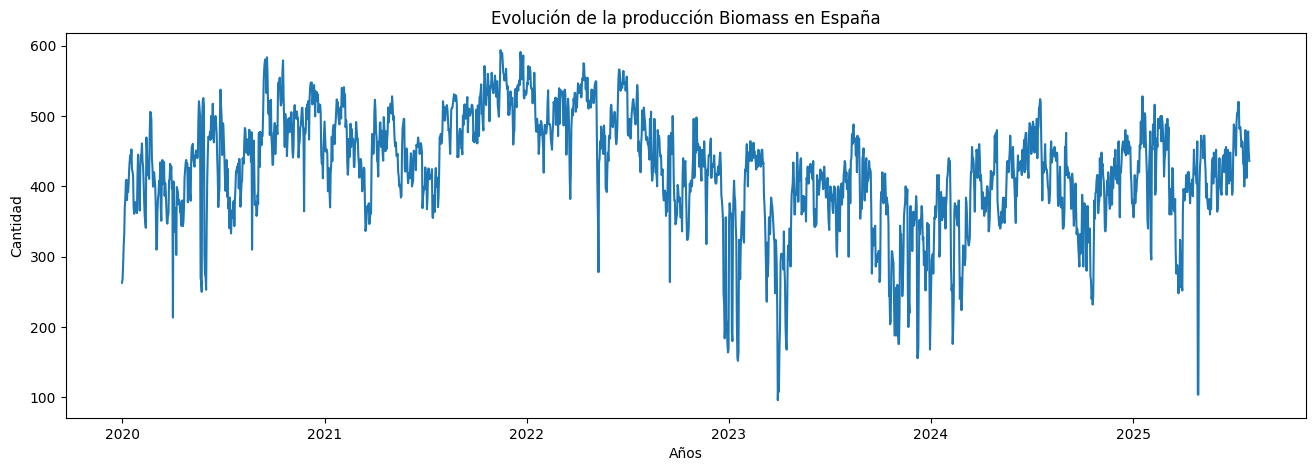

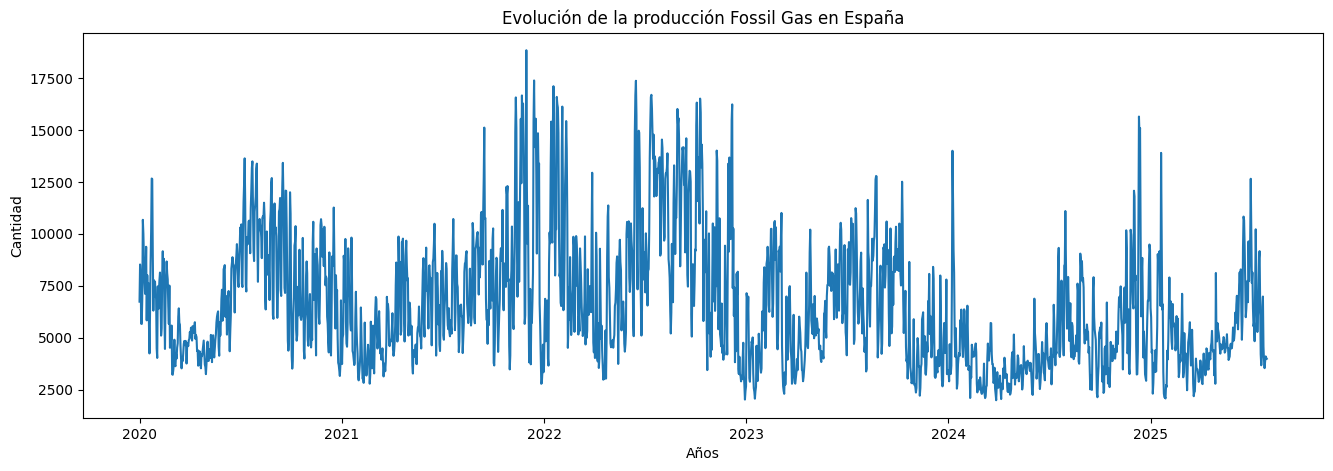

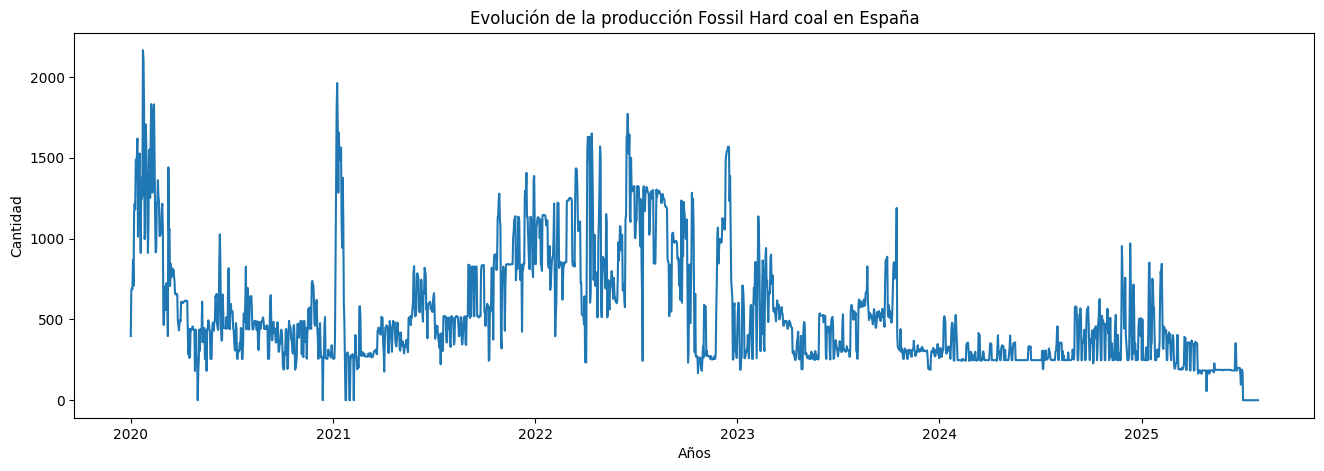

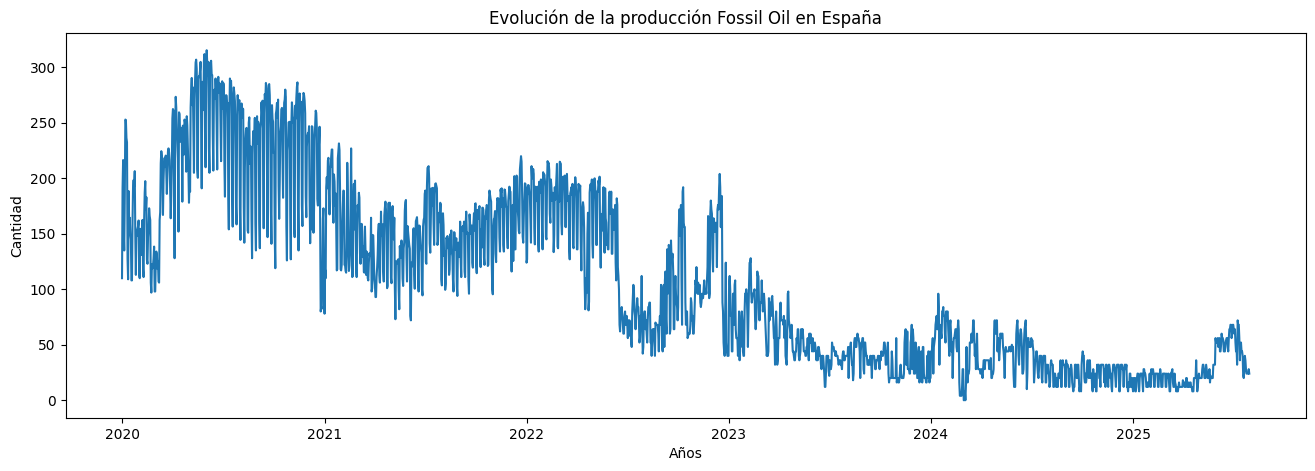

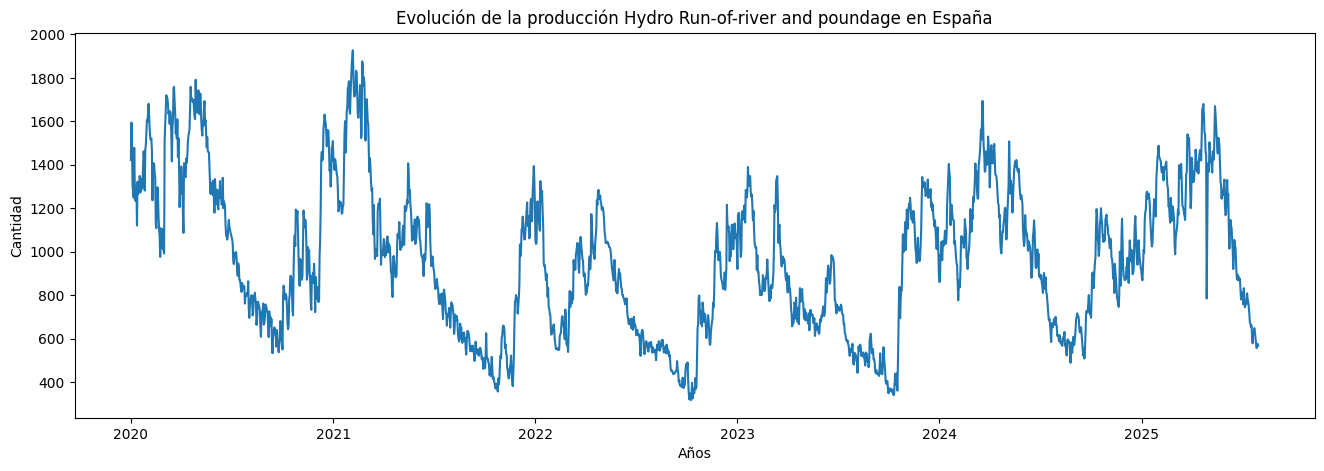

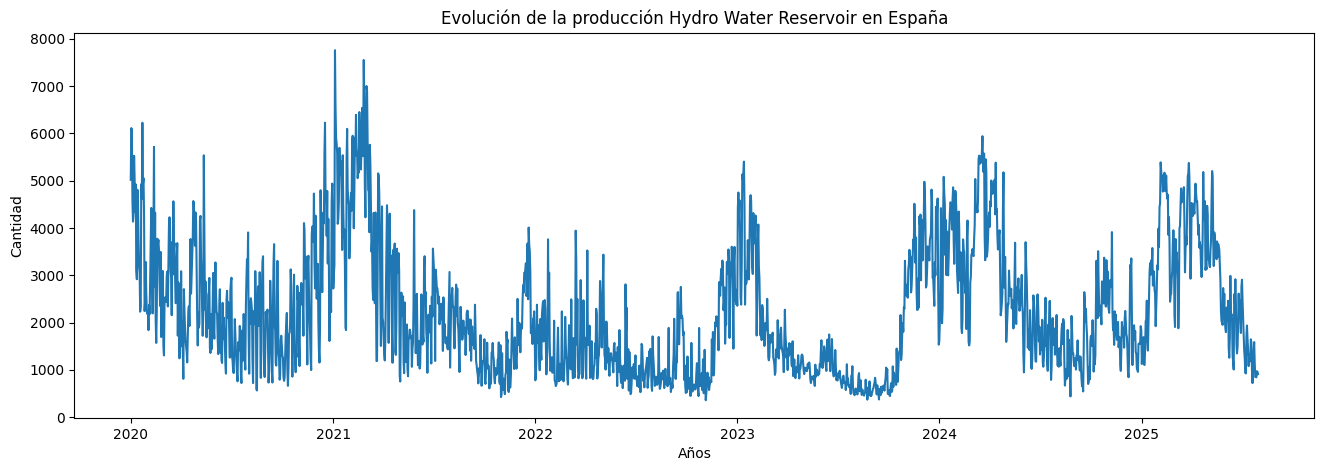

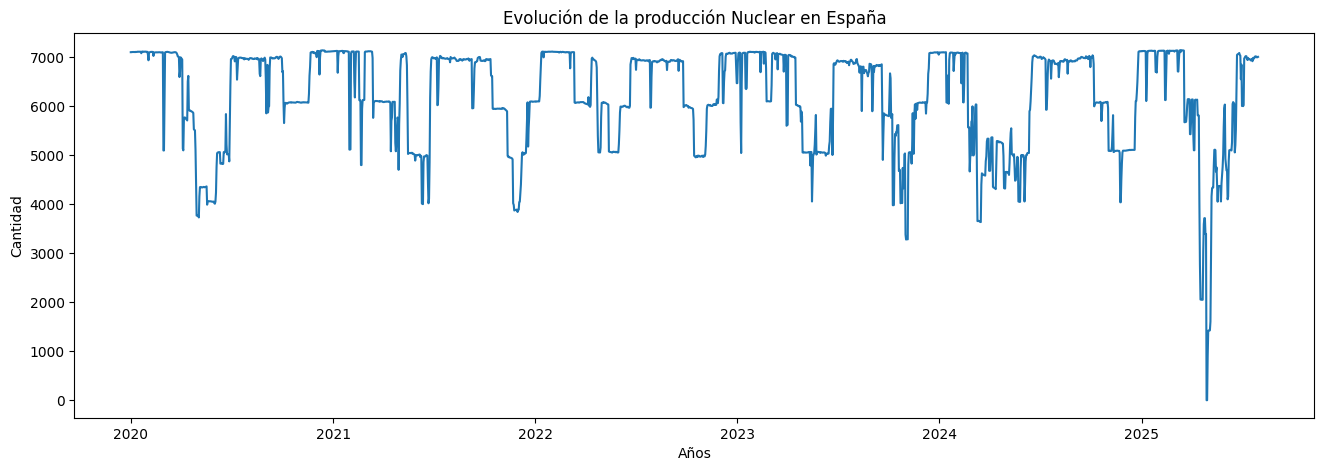

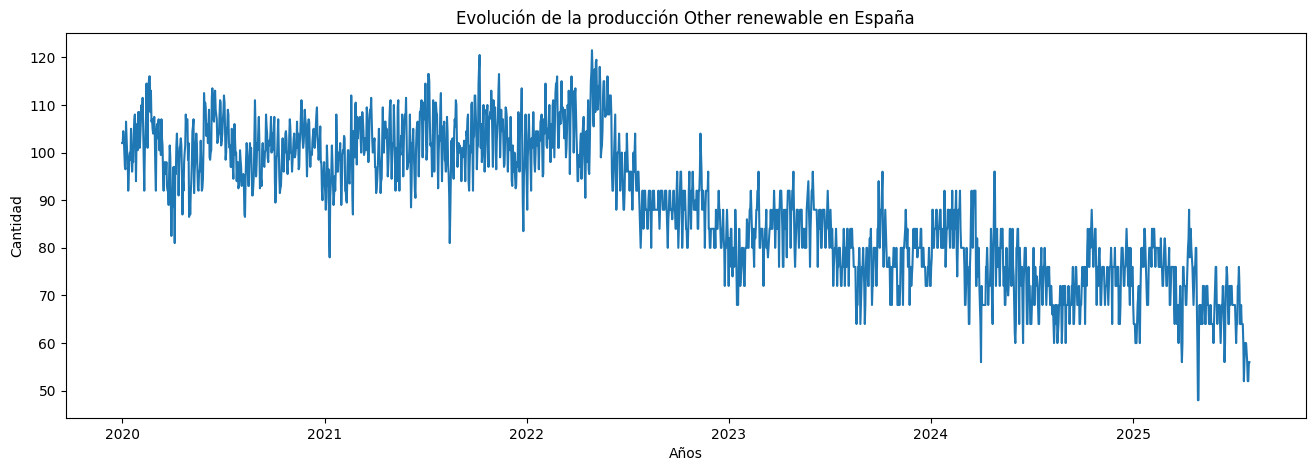

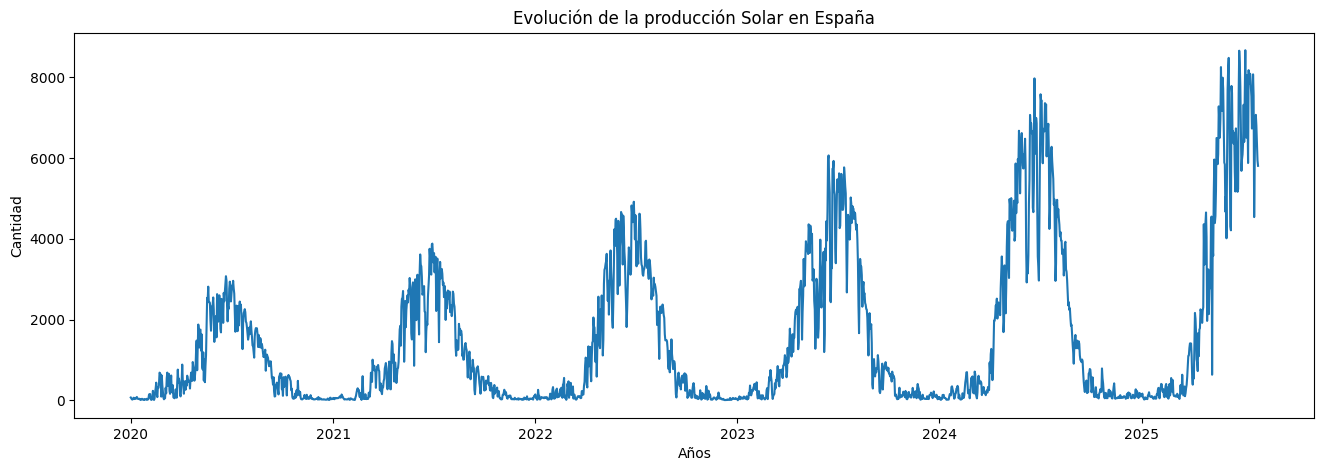

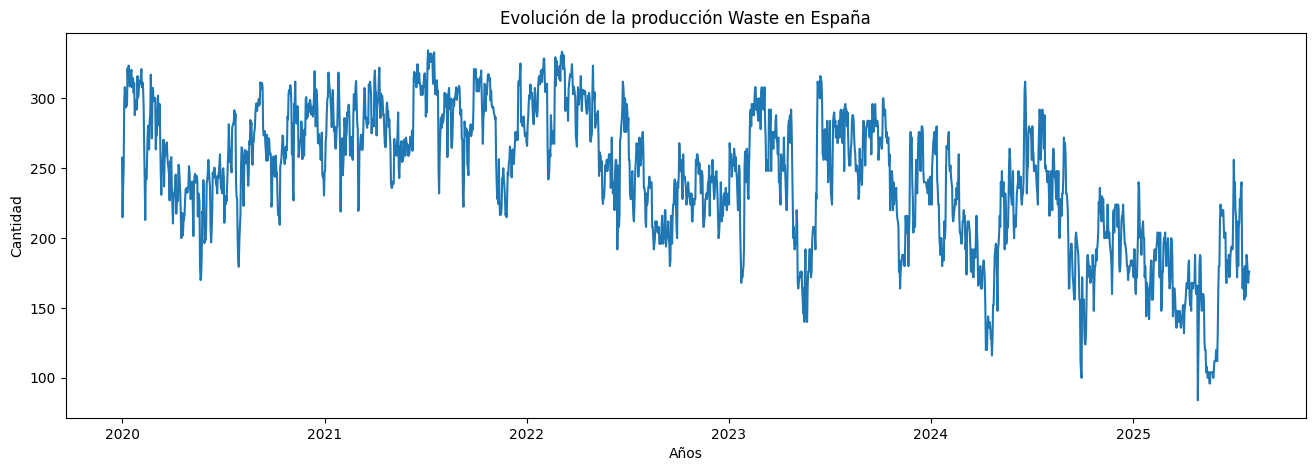

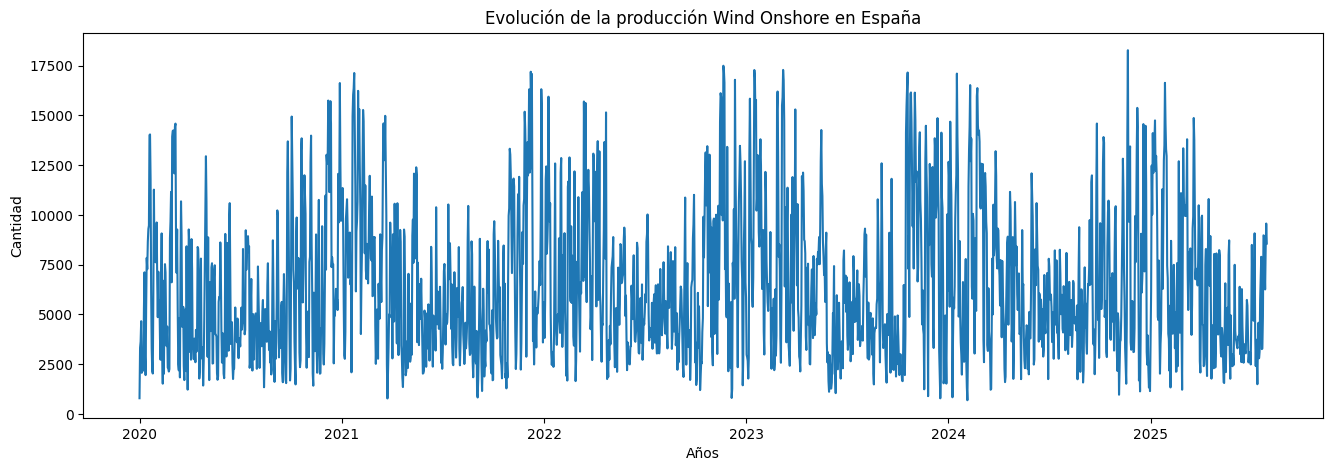

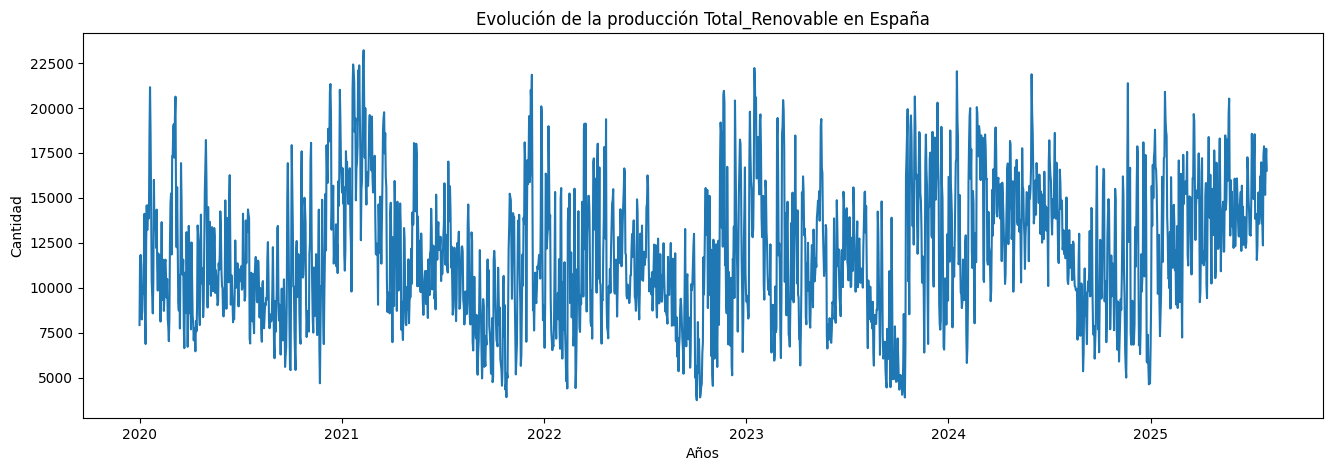

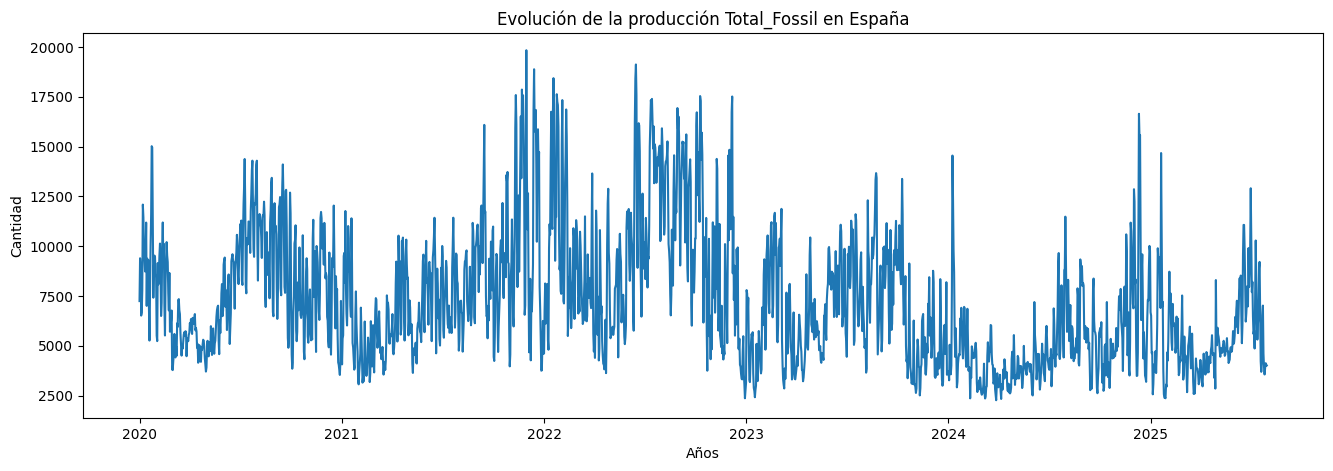

In [22]:
# Pinto todos los datos aunque las 5 columnas a estudiar serán Total_Renovable, Total_Fossil, Nuclear, Solar y Gas
for column in df_diario.columns:
    plt.figure(figsize=(16,5), dpi=100)
    plt.plot(df_diario.index, df_diario[column])
    plt.gca().set(title=f"Evolución de la producción {column} en España", xlabel='Años', ylabel='Cantidad')
    plt.show()

In [23]:
# Nos quedamos solo con las columnas Total_Renovable, Total_Fossil, Nuclear, Solar y Fossil Gas.
df_time_series  = df_diario[['Total_Renovable', 'Total_Fossil', 'Nuclear', 'Solar', 'Fossil Gas']]
df_time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2038 entries, 2020-01-01 to 2025-07-30
Freq: D
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Total_Renovable  2038 non-null   float64
 1   Total_Fossil     2038 non-null   float64
 2   Nuclear          2038 non-null   float64
 3   Solar            2038 non-null   float64
 4   Fossil Gas       2038 non-null   float64
dtypes: float64(5)
memory usage: 95.5 KB


In [78]:
# Separo en train e test, donde y será el més de Julio de 2025
train = df_time_series.loc[(df_time_series.index < '2025-07-01'), :]
test = df_time_series.loc[df_time_series.index > '2025-06-30', :]
test.index = pd.to_datetime(test.index)
train.shape, test.shape

((2008, 5), (30, 5))

Estudio de seasonality, descomposición de la serie para observar la tendencia, seasonality y residuos.

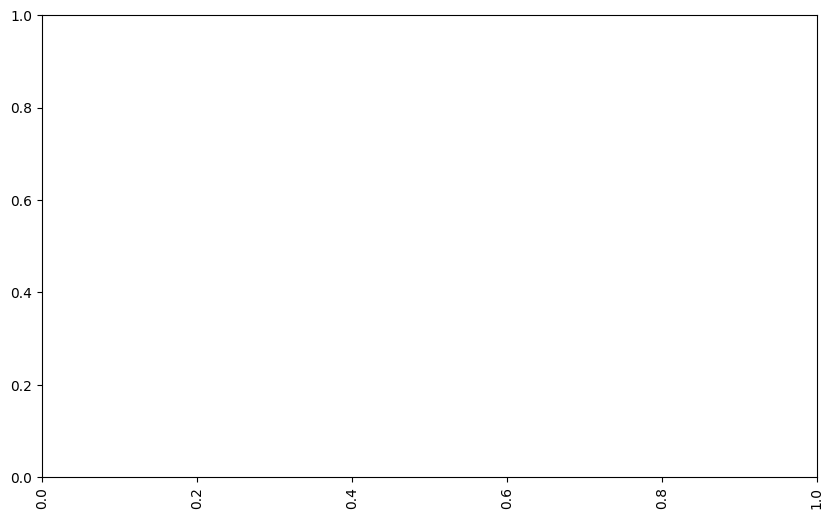

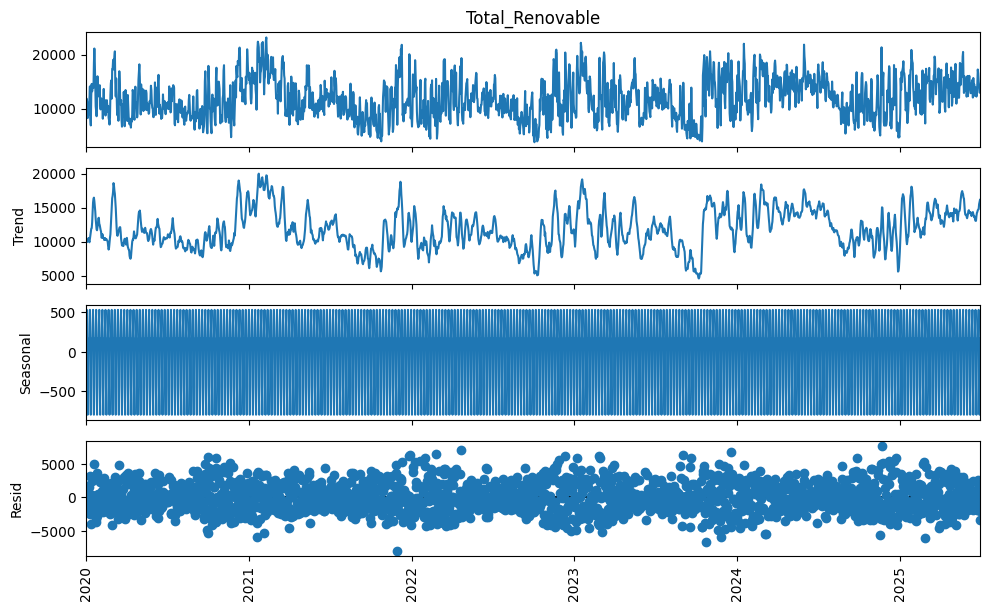

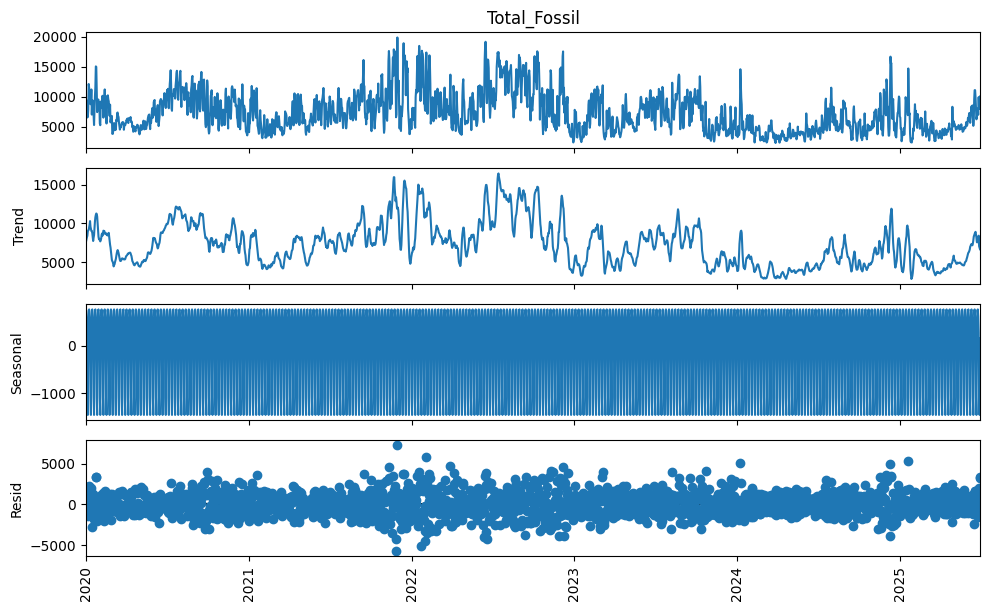

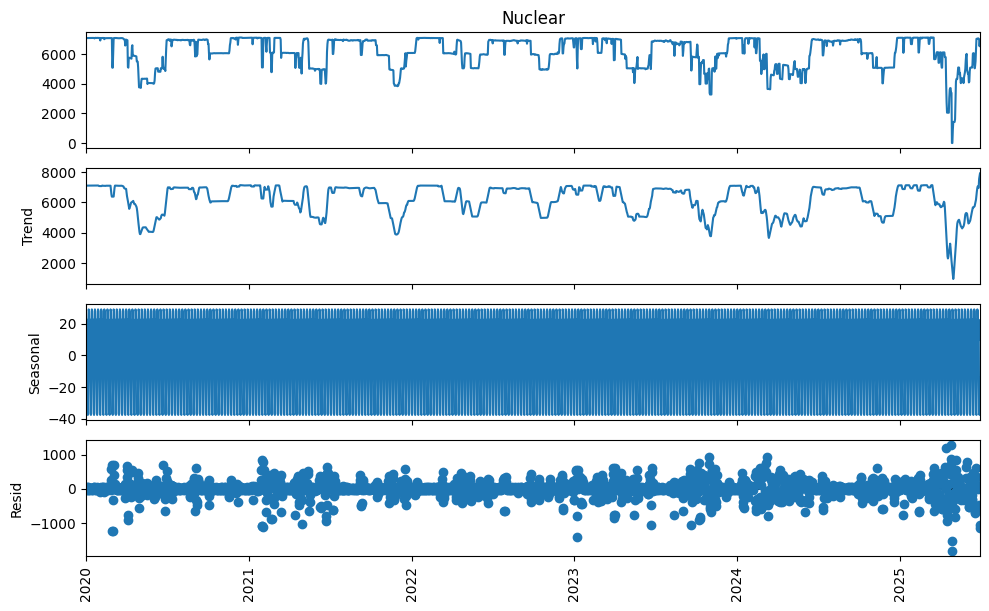

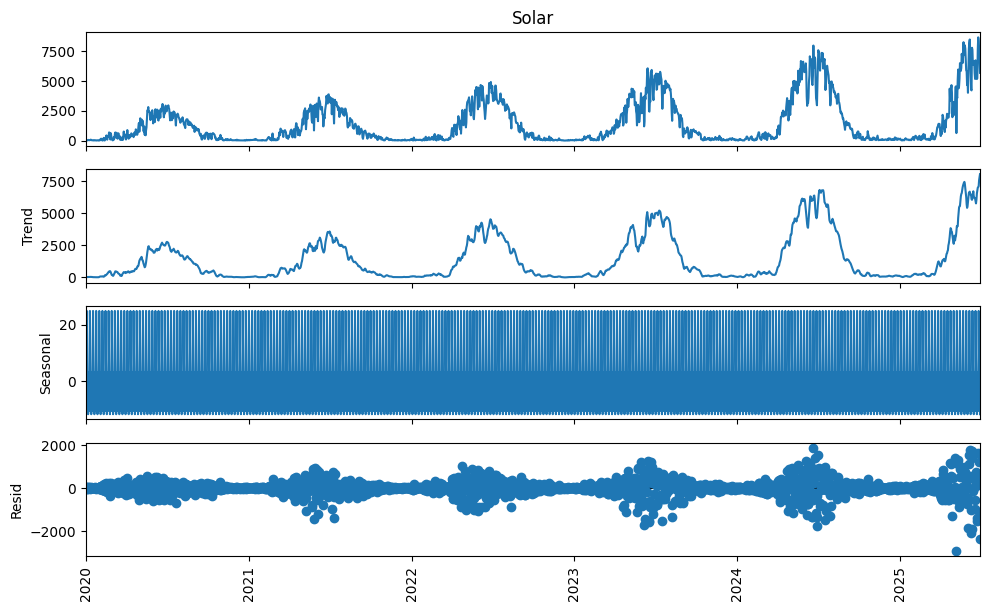

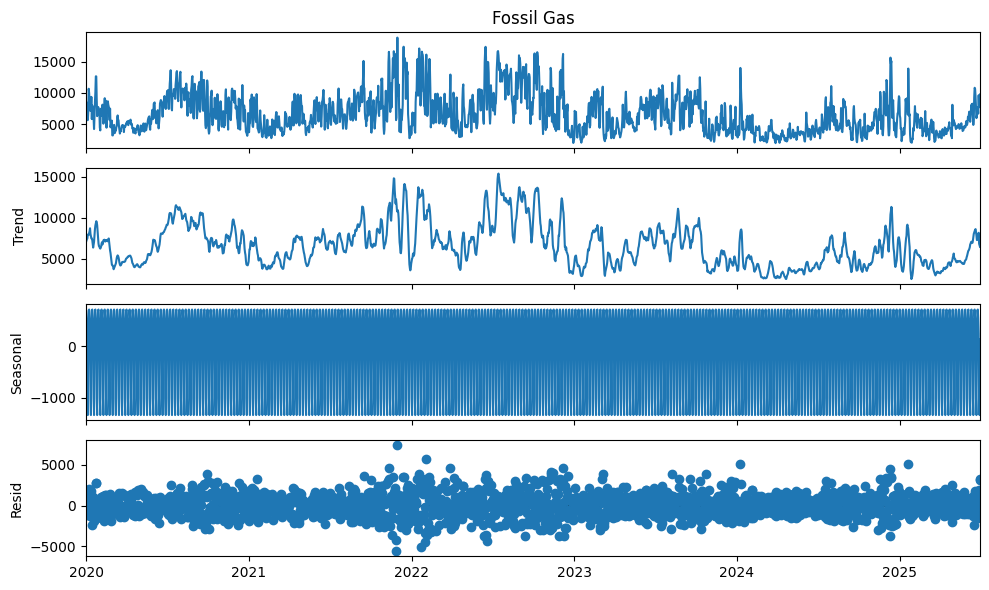

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

for column in train.columns:
    decomposed = seasonal_decompose(train[column], model='additive', extrapolate_trend='freq')
    
    plt.rcParams.update({'figure.figsize': (10,6)})
    plt.xticks(rotation= 90)
    decomposed.plot();

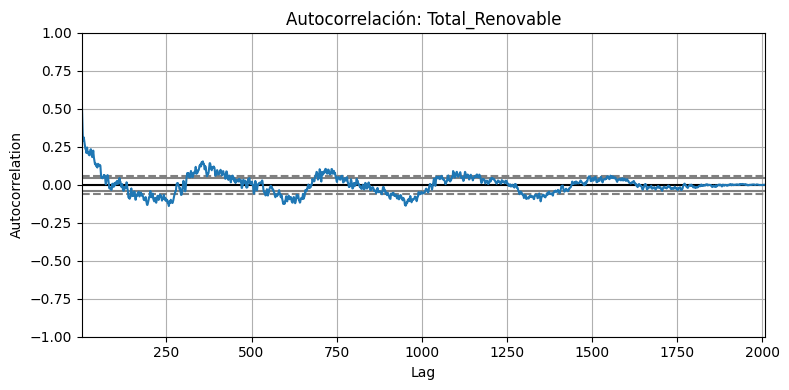

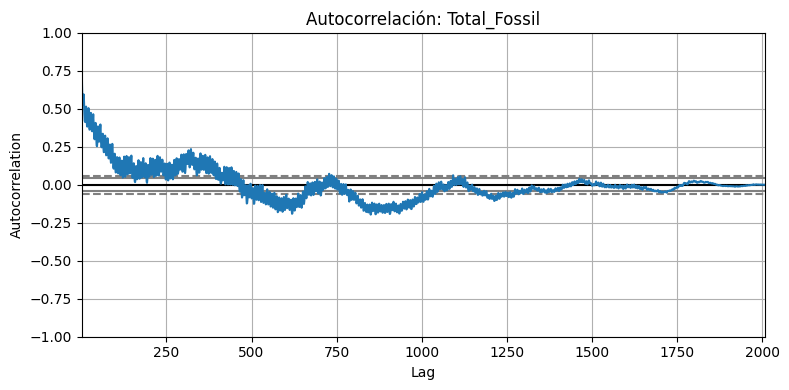

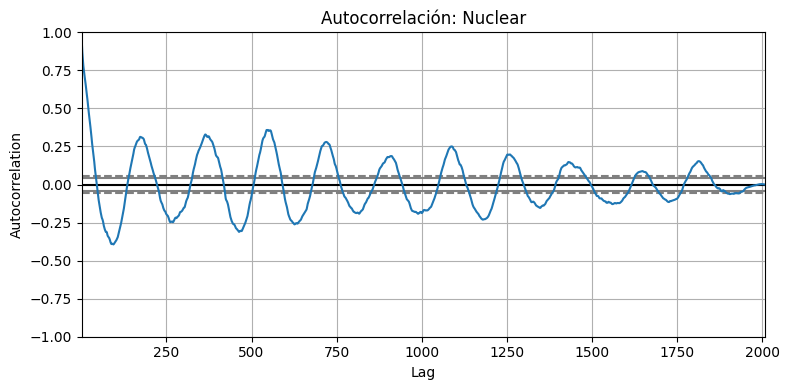

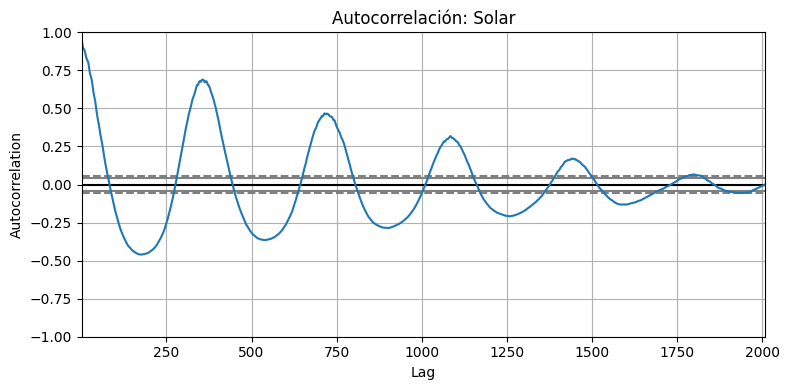

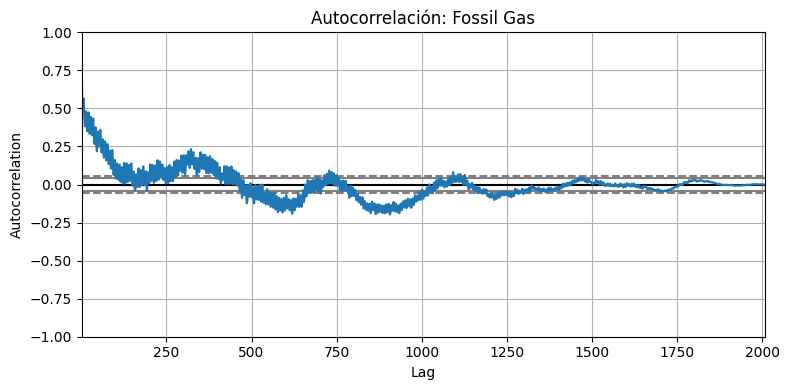

In [50]:
# Pintamos autocorrelación 
from pandas.plotting import autocorrelation_plot

for column in train.columns:
    plt.figure(figsize=(8, 4))
    plt.title(f'Autocorrelación: {column}')
    autocorrelation_plot(train[column])
    plt.tight_layout()
    plt.show()

## Creo un grafrico con la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenid anteriormente

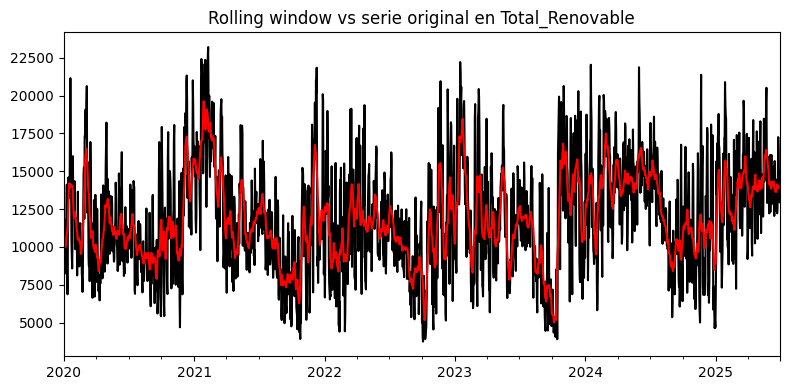

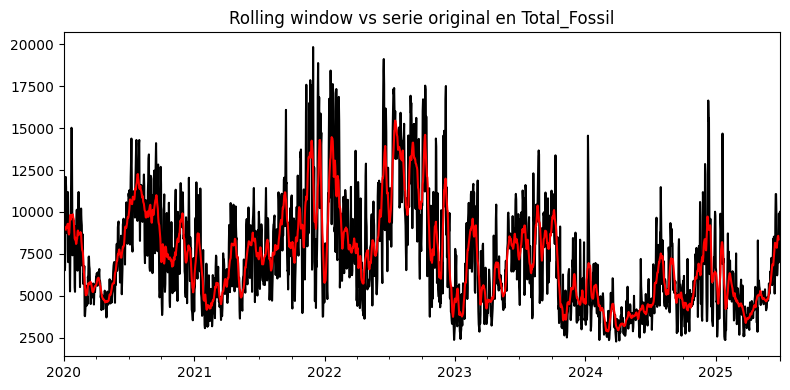

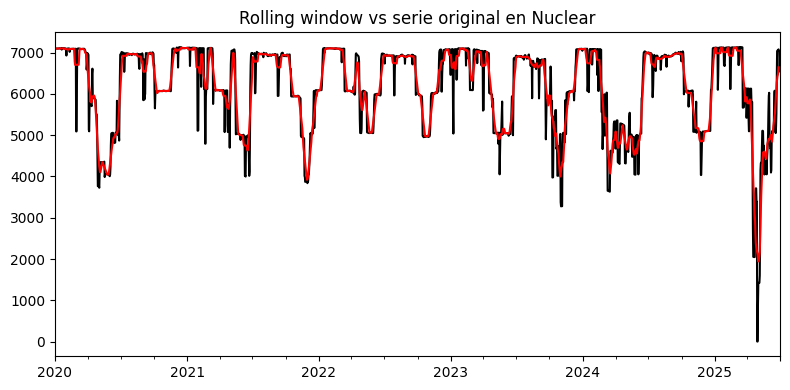

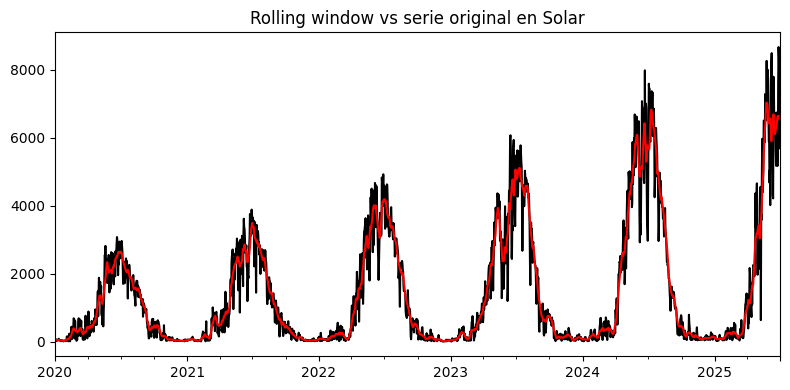

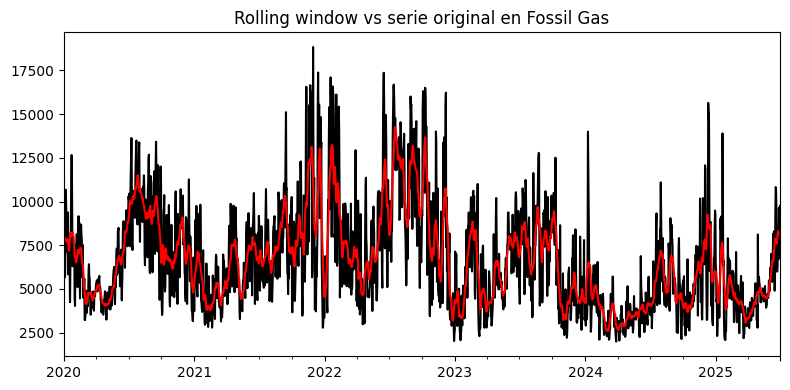

In [51]:
for column in train.columns:
    s = 12

    df_ma = train[column].rolling(s, center=True, closed='both').mean()
    plt.figure(figsize=(8, 4))
    train[column].plot(color='k')
    df_ma.plot(color = 'r', title=f'Rolling window vs serie original en {column}');
    plt.tight_layout()
    plt.show()

## Compruevo de manera estadística si la serie es o no stationary.

Una serie es estacionaria si sus propiedades estadísticas (media, varianza, autocorrelación, etc.) no cambian en el tiempo. Esto es un requisito importante para muchos modelos de series temporales

##### El test ADF tiene esta lógica:
* H₀ (hipótesis nula): La serie NO es estacionaria (tiene raíz unitaria).

* H₁ (hipótesis alternativa): La serie es estacionaria.

Por tanto:

* Si p-value < 0.05 → Rechazamos H₀ → ✅ Serie estacionaria

* Si p-value ≥ 0.05 → No podemos rechazar H₀ → ❌ Serie no estacionaria

##### Resultado de mi test ADF:
| Columna          | ADF Statistic | p-value  | ¿Estacionaria? (ADF) |
| ---------------- | ------------- | -------- | -------------------- |
| Total\_Renovable | -4.7548       | 0.000066 | ✅ Sí (p < 0.05)      |
| Total\_Fossil    | -3.4129       | 0.010528 | ✅ Sí                 |
| Nuclear          | -5.3212       | 0.000005 | ✅ Sí                 |
| Solar            | -2.6286       | 0.087226 | ❌ No (p > 0.05)      |
| Fossil Gas       | -3.4995       | 0.008001 | ✅ Sí                 |

##### Conclusiones
* A diferencia del test anterior, que hice solo con los datos de el último año, la mayoría de las series son estacionarias según el test ADF.

* Solo la serie "Solar" no es estacionaria (p ≈ 0.087), por lo que si fuéramos a utilizar modelos como ARIMA, requeriría algún tipo de transformación (como diferenciación o log).

* Como planeo usar Prophet, que no requiere series estacionarias, puedo alimentar el modelo directamente con los datos originales (hasta 2020).

* También haré una comparación con modelos de aprendizaje automático, como DecisionTree, que tampoco requieren estacionariedad.



In [52]:
from statsmodels.tsa.stattools import adfuller

for column in train.columns:
    result = adfuller(train[column])
    print('=='*30)
    print(f'Comprovación de stationary en la columna {column}')
    print('=='*30)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

Comprovación de stationary en la columna Total_Renovable
ADF Statistic: -4.754810
p-value: 0.000066
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Comprovación de stationary en la columna Total_Fossil
ADF Statistic: -3.412881
p-value: 0.010528
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Comprovación de stationary en la columna Nuclear
ADF Statistic: -5.321181
p-value: 0.000005
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Comprovación de stationary en la columna Solar
ADF Statistic: -2.628618
p-value: 0.087226
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Comprovación de stationary en la columna Fossil Gas
ADF Statistic: -3.499450
p-value: 0.008001
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [53]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

for column in train.columns:
    # Evitar log de cero o negativo
    if (train[column] <= 0).any():
        print(f"Skipping {column} due to non-positive values")
        continue
    
    # Aplicar log
    log_col = np.log(train[column])
    
    # Quitar NaN si los hay
    log_col = log_col.dropna()
    
    # Verificar varianza
    if log_col.var() == 0:
        print(f"Skipping {column} due to zero variance")
        continue
    
    # Aplicar ADF
    try:
        result = adfuller(log_col)
        print(f'Column: {column}')
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print('----------------------------')
    except Exception as e:
        print(f"Error al aplicar adfuller en {column}: {e}")


Column: Total_Renovable
ADF Statistic: -4.805557475487395
p-value: 5.307012503641583e-05
----------------------------
Column: Total_Fossil
ADF Statistic: -3.4441413270628556
p-value: 0.009543040113997843
----------------------------
Skipping Nuclear due to non-positive values
Skipping Solar due to non-positive values
Column: Fossil Gas
ADF Statistic: -3.5460621417731173
p-value: 0.006879988773852465
----------------------------


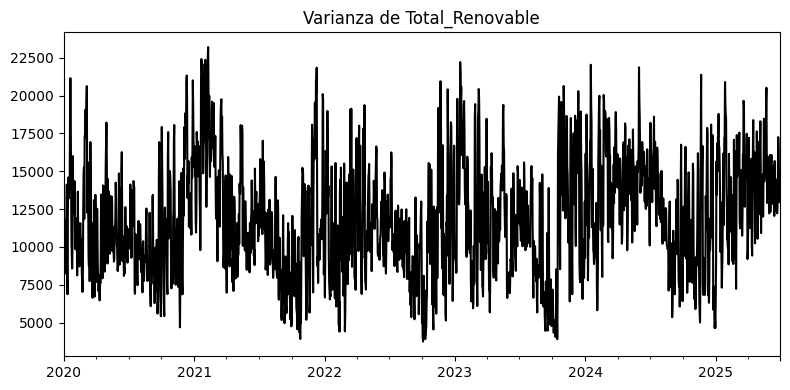

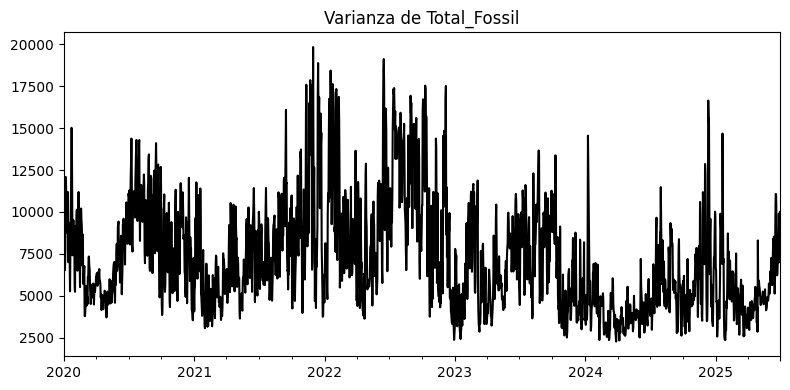

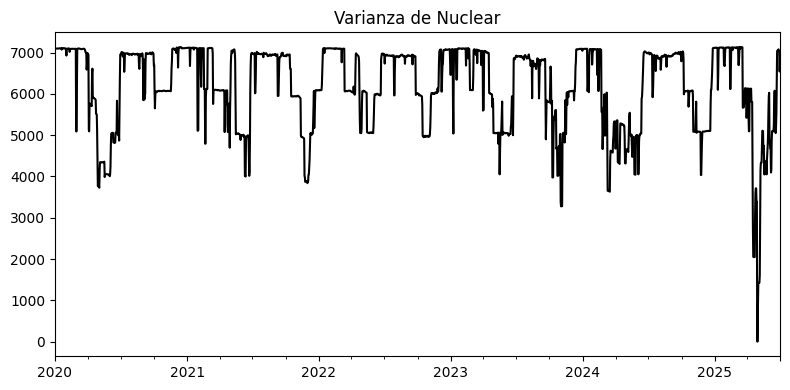

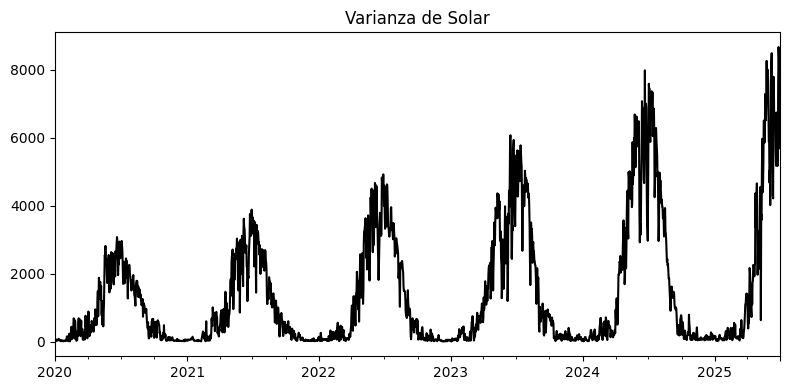

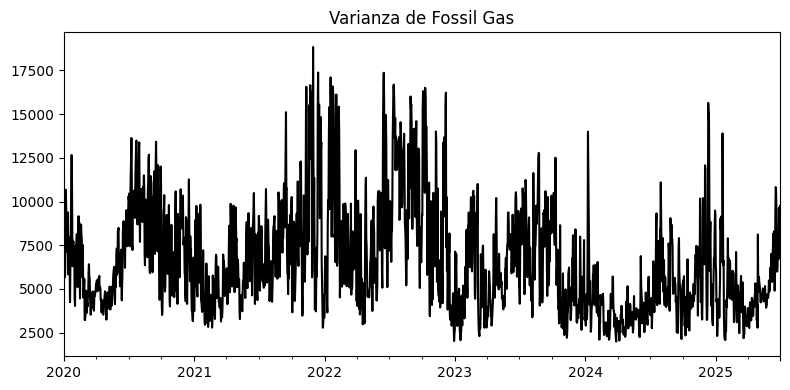

In [54]:
for column in train.columns:
    plt.figure(figsize=(8, 4))
    train[column].plot(color='k')
    plt.title(f'Varianza de {column}')
    plt.tight_layout()
    plt.show()
    

In [91]:
train = df_time_series.loc[(df_time_series.index < '2025-07-01'), :]

In [92]:
prophet_model_list = {}
for column in train.columns:
    df_train = train[column].reset_index().rename(columns={'index':'ds', column:'y'})
    pm = Prophet(
            changepoint_prior_scale=0.1,
            seasonality_prior_scale=1.0,
            holidays_prior_scale=0.1,
            seasonality_mode='multiplicative',
            changepoint_range=0.9,
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False
        )
    pm.fit(df_train)
    prophet_model_list[f'{column}_model'] = pm

13:22:45 - cmdstanpy - INFO - Chain [1] start processing
13:22:45 - cmdstanpy - INFO - Chain [1] done processing
13:22:46 - cmdstanpy - INFO - Chain [1] start processing
13:22:47 - cmdstanpy - INFO - Chain [1] done processing
13:22:48 - cmdstanpy - INFO - Chain [1] start processing
13:22:49 - cmdstanpy - INFO - Chain [1] done processing
13:22:50 - cmdstanpy - INFO - Chain [1] start processing
13:22:52 - cmdstanpy - INFO - Chain [1] done processing
13:22:53 - cmdstanpy - INFO - Chain [1] start processing
13:22:54 - cmdstanpy - INFO - Chain [1] done processing


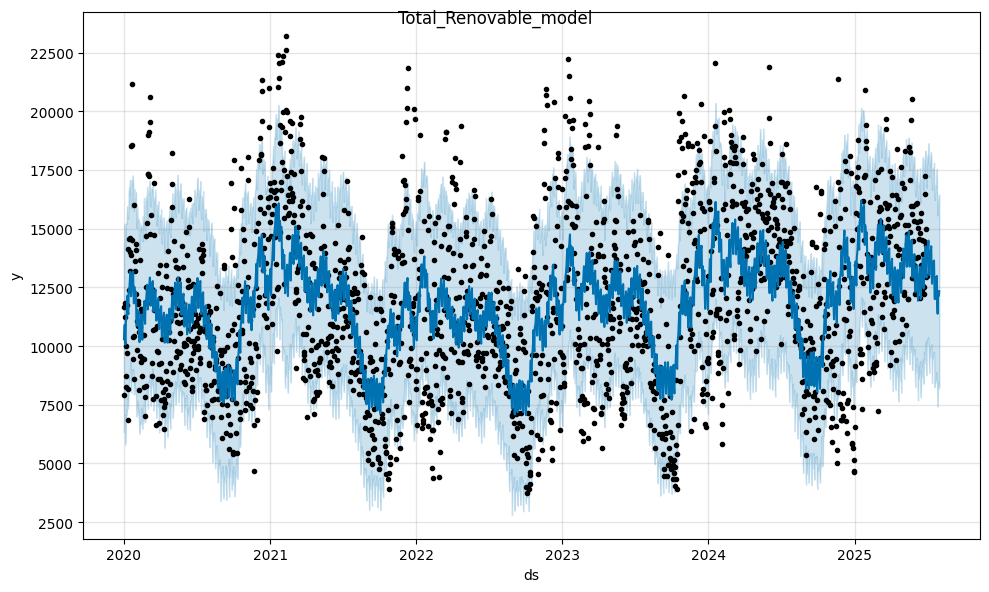

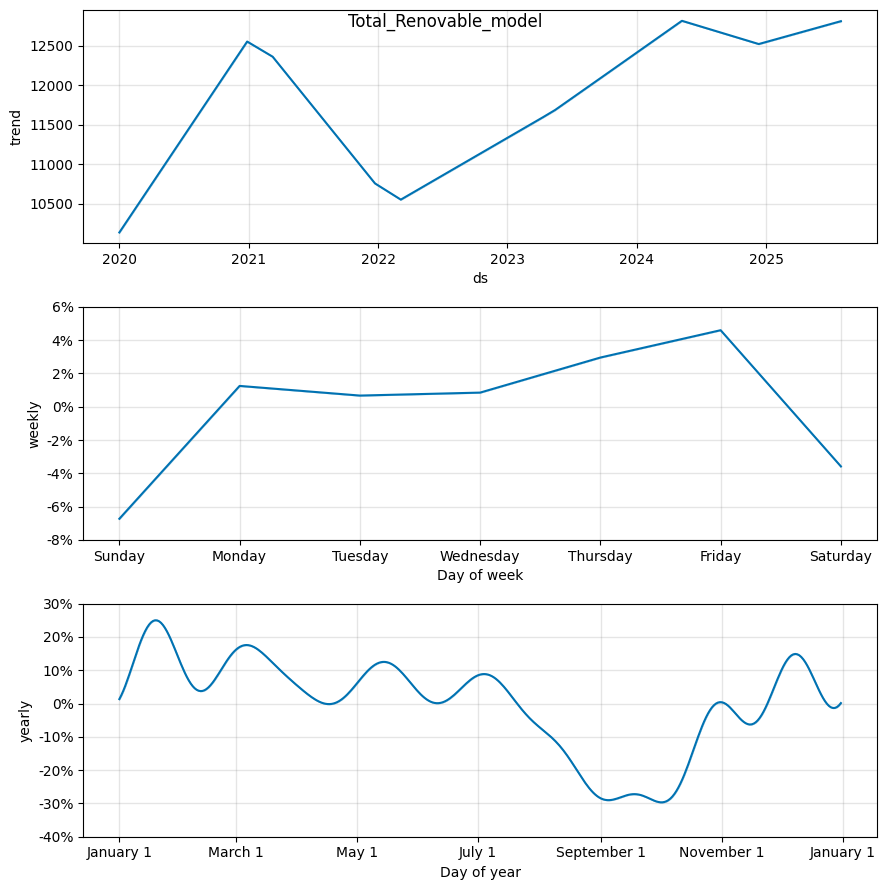

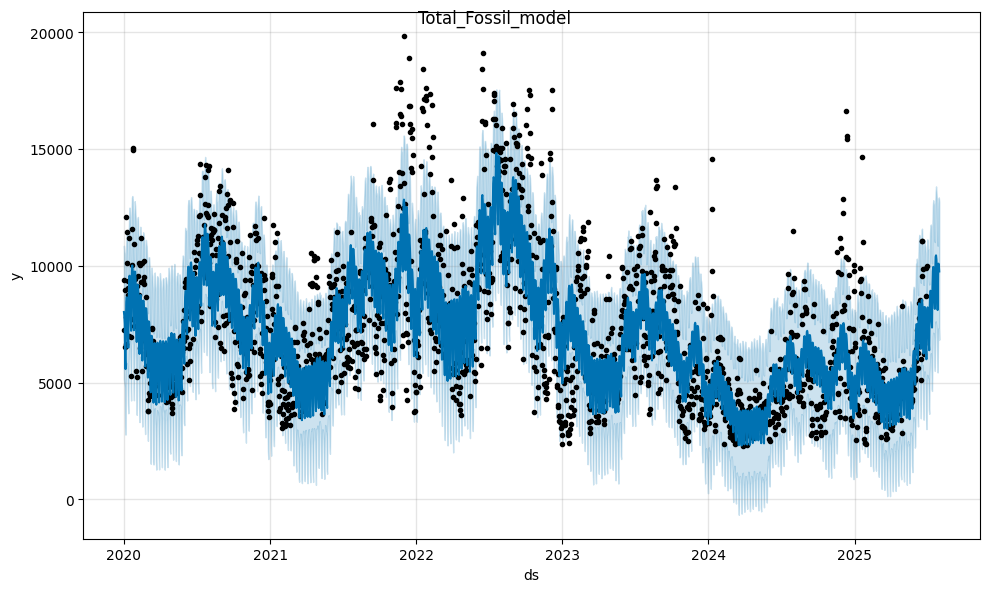

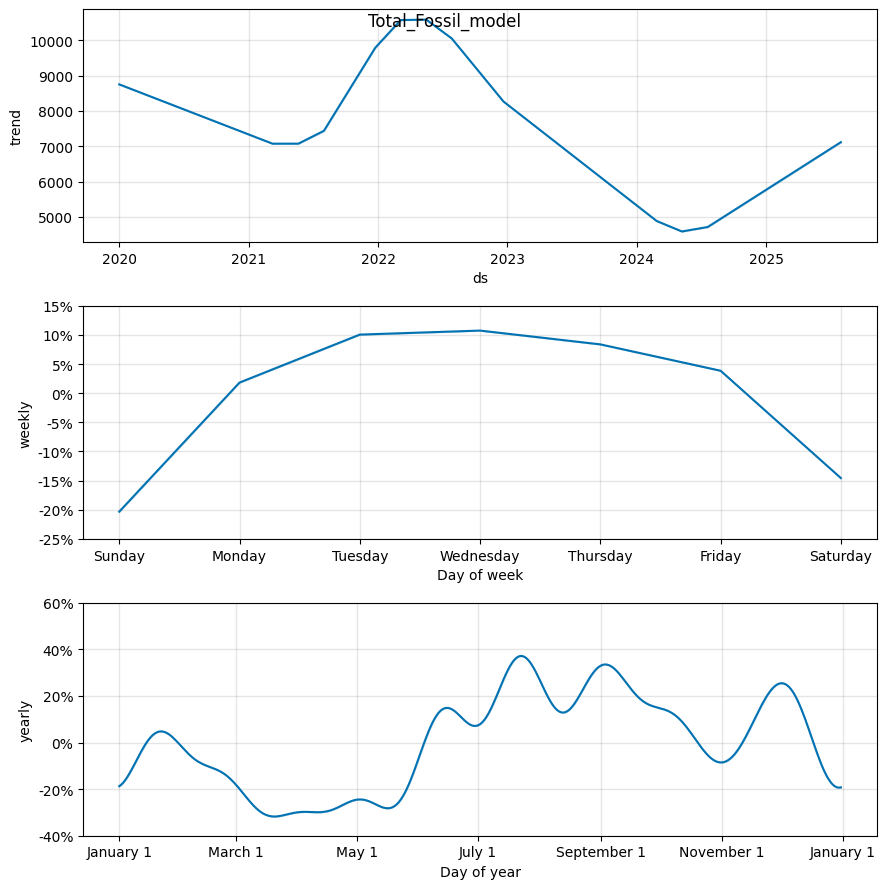

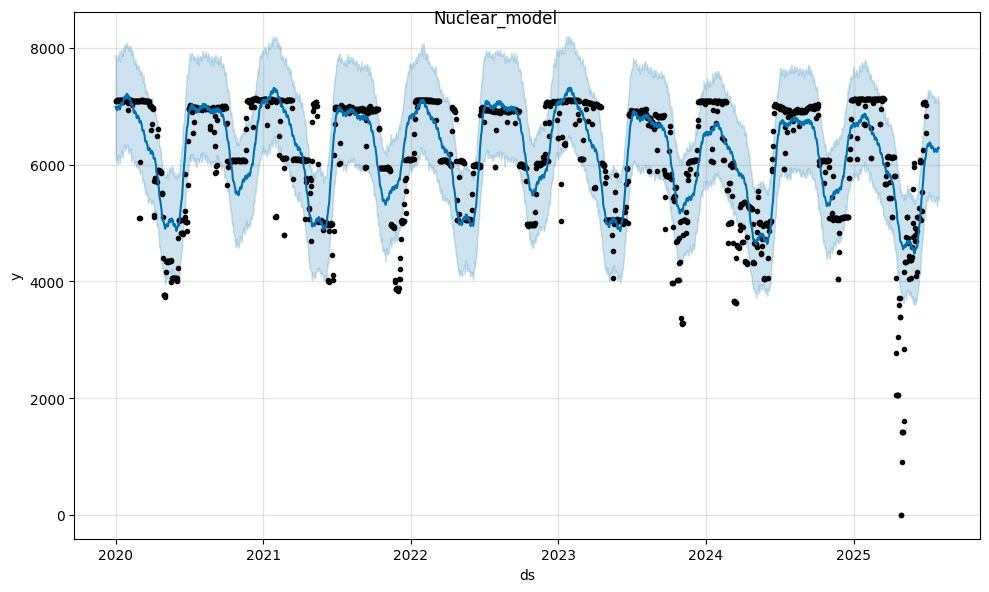

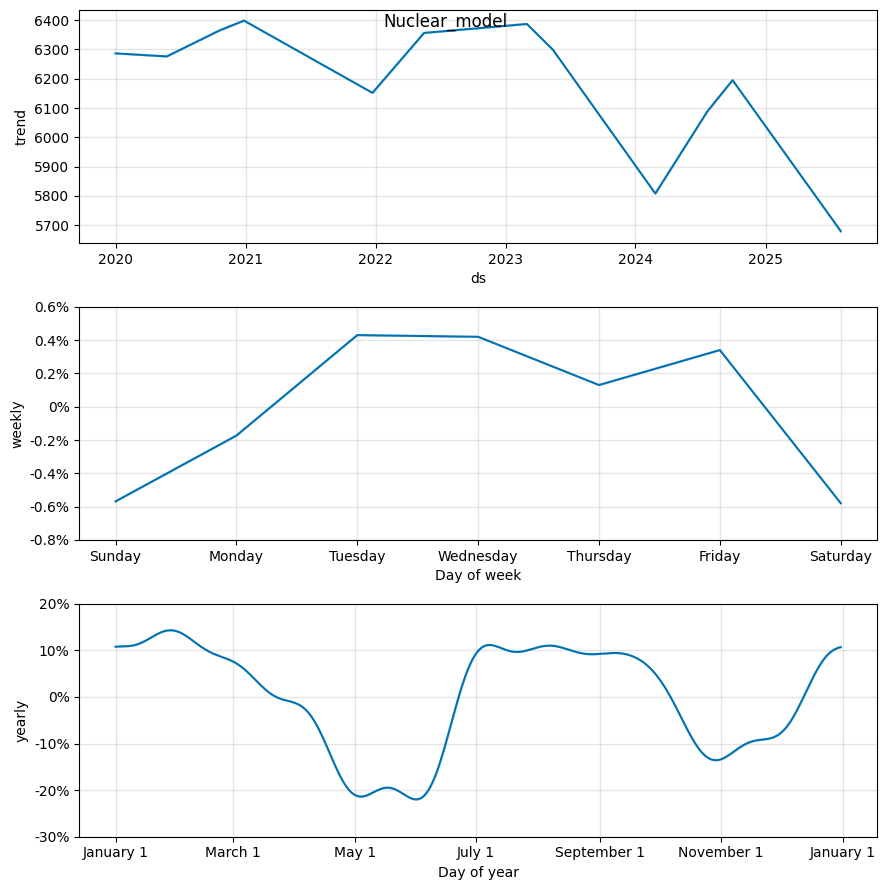

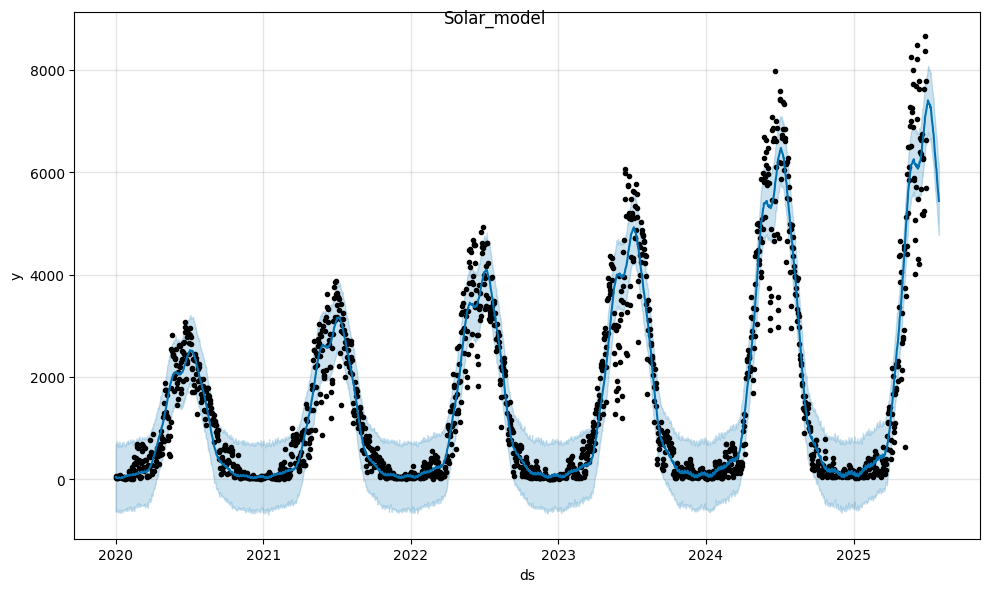

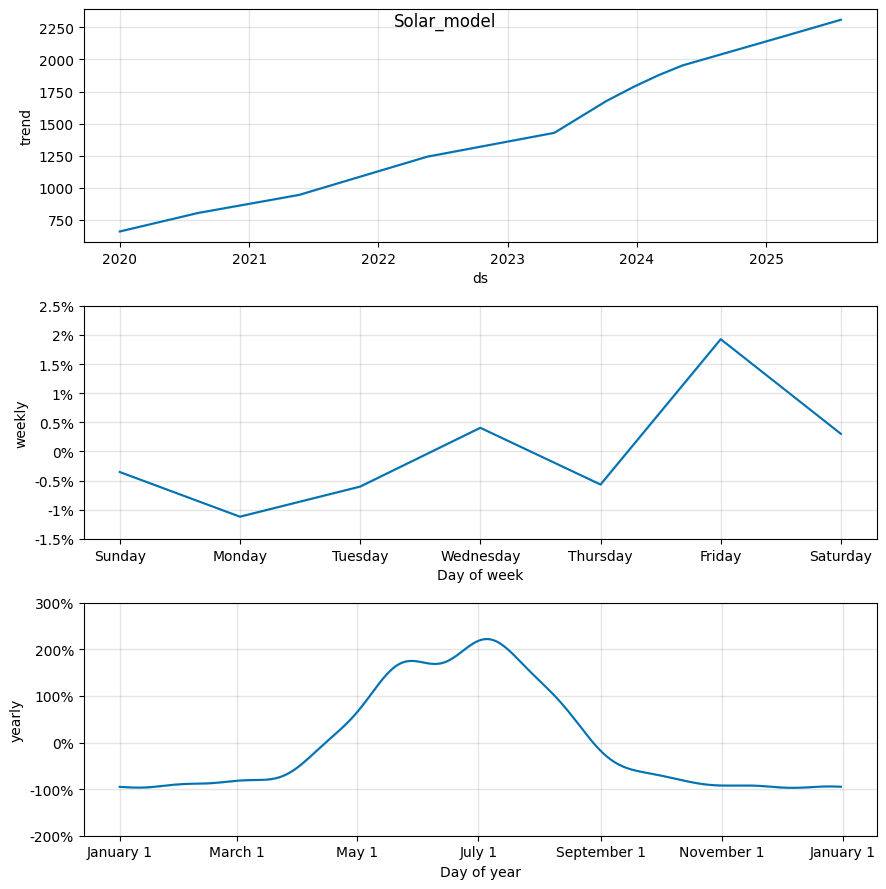

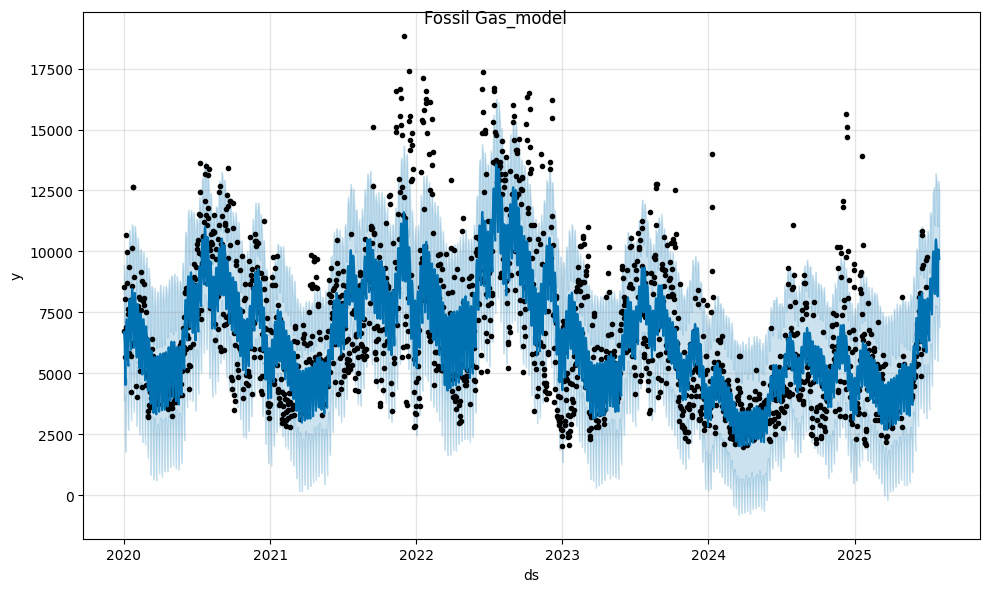

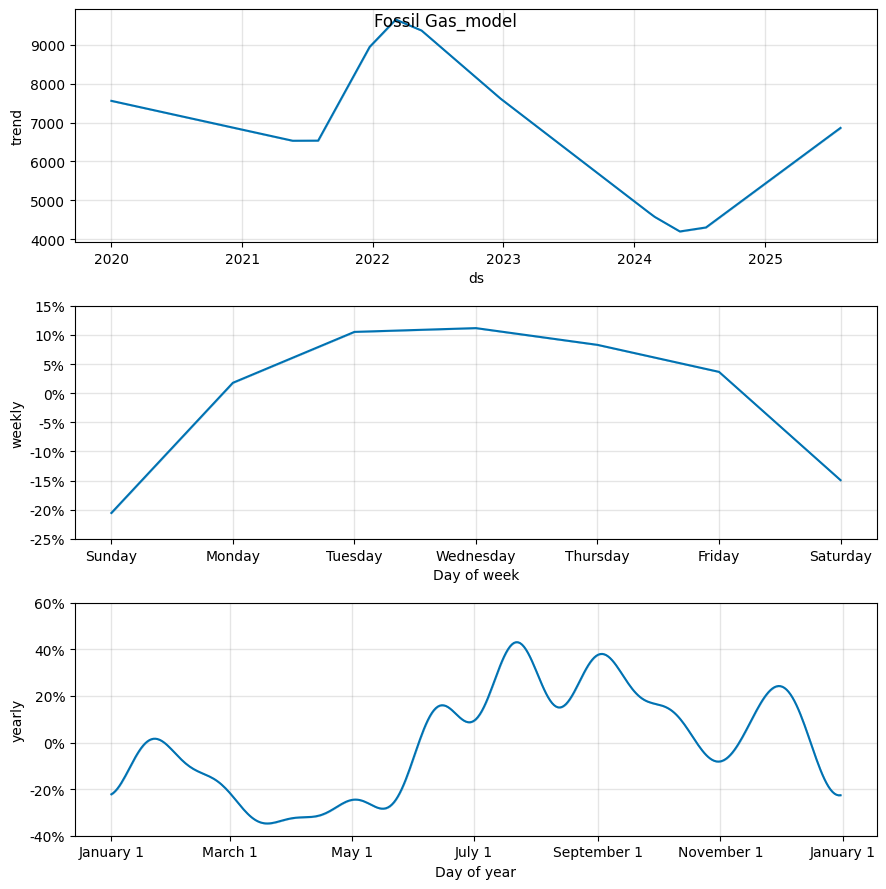

In [93]:
prophet_predictions = {}
for key, model in prophet_model_list.items():
    future = future = model.make_future_dataframe(periods=31)
    forecast = model.predict(future)
    fig1 = model.plot(forecast)
    fig1.suptitle(key)
    fig2 = model.plot_components(forecast)
    fig2.suptitle(key)
    prophet_predictions[f'{key}_prediction'] = forecast

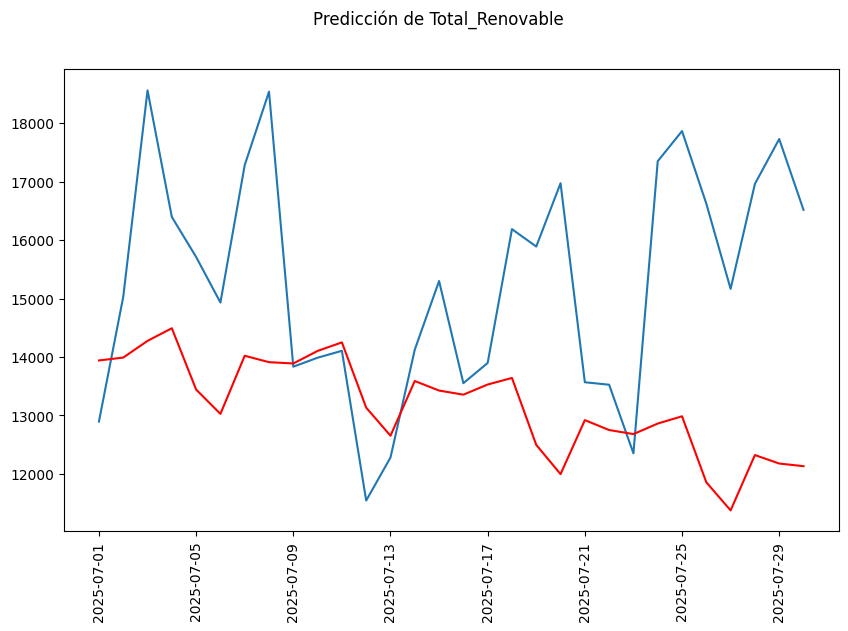

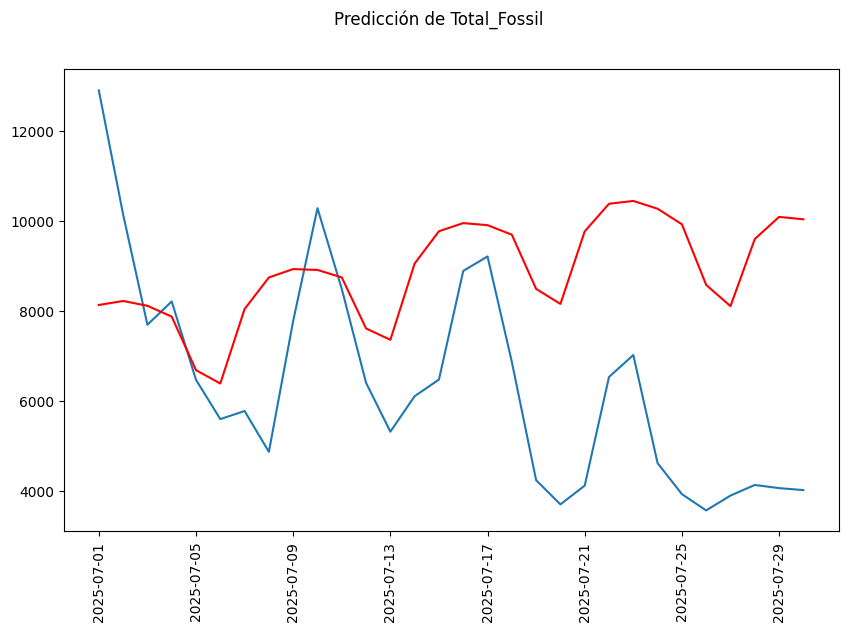

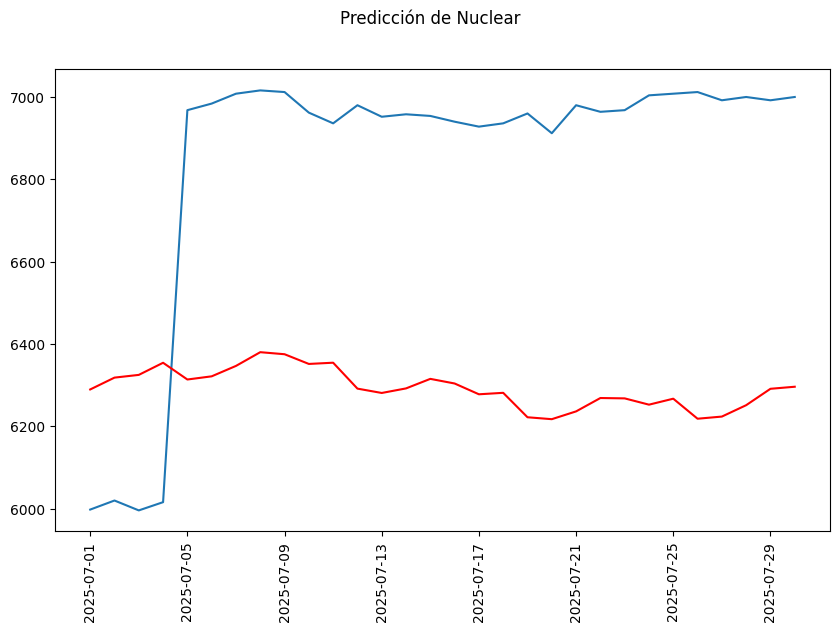

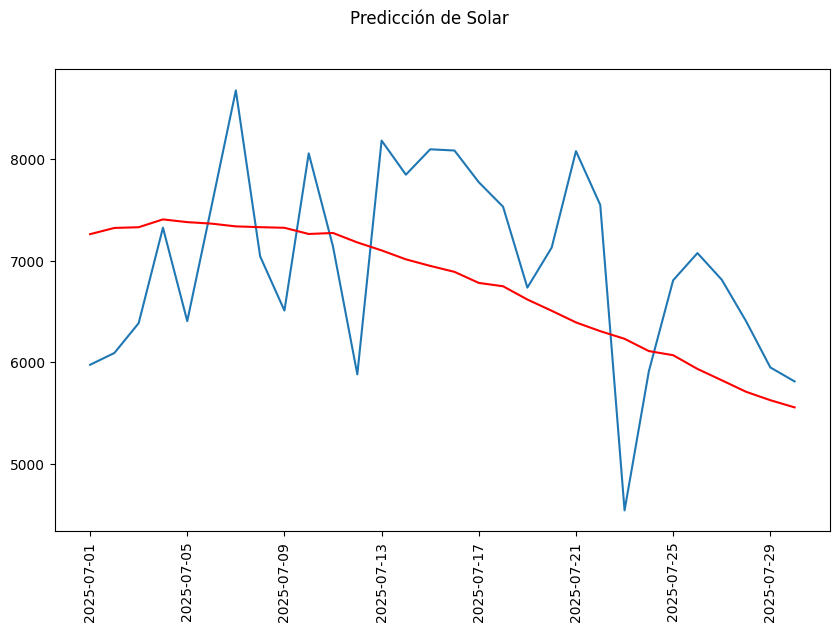

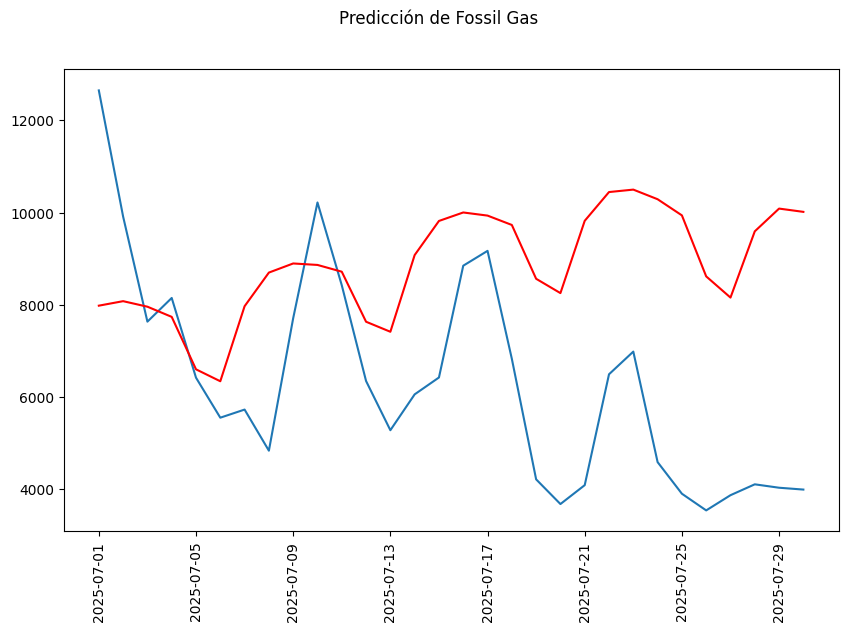

In [ ]:
for x, y in zip(test.columns, prophet_predictions.keys()):
    real = test[x]
    prediction = prophet_predictions[y][['ds', 'yhat']].set_index('ds')
    merged = pd.merge(real, prediction, how='left', left_index=True, right_index=True)
    plt.figure((10.6))
    plt.plot(merged[x])
    plt.plot(merged['yhat'], color= 'red')
    plt.suptitle(f'Predicción de {x}')
    plt.xticks(rotation=90)
    plt.show();

## Pruebo otros modelos, a ver qué performance presentan.

In [183]:
tipo_energia_dfs_dic = {}
for column in df_time_series.columns:
    df_temp = df_time_series[[column]]
    for i in range(31,0,-1):
        df_temp['t-'+str(i)] = df_time_series[column].shift(i)
    tipo_energia_dfs_dic[column] = df_temp.dropna()
tipo_energia_dfs_dic['Solar']

Solar    t-31    t-30    t-29    t-28    t-27    t-26    t-25  \
2020-02-01    17.0    67.5    47.0    21.0    17.0    29.5    61.0    57.0   
2020-02-02    42.0    47.0    21.0    17.0    29.5    61.0    57.0    28.5   
2020-02-03   140.0    21.0    17.0    29.5    61.0    57.0    28.5    37.5   
2020-02-04   153.5    17.0    29.5    61.0    57.0    28.5    37.5    36.5   
2020-02-05   152.0    29.5    61.0    57.0    28.5    37.5    36.5    63.5   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2025-07-26  7074.0  7618.0  8664.0  8360.0  7774.0  6636.0  5686.0  5974.0   
2025-07-27  6812.0  8664.0  8360.0  7774.0  6636.0  5686.0  5974.0  6090.0   
2025-07-28  6404.0  8360.0  7774.0  6636.0  5686.0  5974.0  6090.0  6384.0   
2025-07-29  5948.0  7774.0  6636.0  5686.0  5974.0  6090.0  6384.0  7324.0   
2025-07-30  5810.0  6636.0  5686.0  5974.0  6090.0  6384.0  7324.0  6404.0   

              t-24    t-23  ...    t-10     t-9     t-8     t-7     t-6  \
2020-02-01    28.5    37.5  ...    34.0    16.0     9.0     7.0    30.0   
2020-02-02    37.5    36.5  ...    16.0     9.0     7.0    30.0    20.5   
2020-02-03    36.5    63.5  ...     9.0     7.0    30.0    20.5    19.0   
2020-02-04    63.5    81.0  ...     7.0    30.0    20.5    19.0    16.5   
2020-02-05    81.0    39.0  ...    30.0    20.5    19.0    16.5    35.5   
...            ...     ...  ...     ...     ...     ...     ...     ...   
2025-07-26  6090.0  6384.0  ...  8084.0  7772.0  7530.0  6734.0  7128.0   
2025-07-27  6384.0  7324.0  ...  7772.0  7530.0  6734.0  7128.0  8078.0   
2025-07-28  7324.0  6404.0  ...  7530.0  6734.0  7128.0  8078.0  7548.0   
2025-07-29  6404.0  7536.0  ...  6734.0  7128.0  8078.0  7548.0  4540.0   
2025-07-30  7536.0  8676.0  ...  7128.0  8078.0  7548.0  4540.0  5910.0   

               t-5     t-4     t-3     t-2     t-1  
2020-02-01    20.5    19.0    16.5    35.5    12.0  
2020-02-02    19.0    16.5    35.5    12.0    17.0  
2020-02-03    16.5    35.5    12.0    17.0    42.0  
2020-02-04    35.5    12.0    17.0    42.0   140.0  
2020-02-05    12.0    17.0    42.0   140.0   153.5  
...            ...     ...     ...     ...     ...  
2025-07-26  8078.0  7548.0  4540.0  5910.0  6806.0  
2025-07-27  7548.0  4540.0  5910.0  6806.0  7074.0  
2025-07-28  4540.0  5910.0  6806.0  7074.0  6812.0  
2025-07-29  5910.0  6806.0  7074.0  6812.0  6404.0  
2025-07-30  6806.0  7074.0  6812.0  6404.0  5948.0  

[2007 rows x 32 columns]

In [239]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

df_prueba= tipo_energia_dfs_dic['Solar']
X = df_prueba.iloc[:, 1:]
y = df_prueba.iloc[:, 0]
X_train = X[:-30]
X_test = X[-30:]
y_train = y[:-30]
y_test = y[-30:]

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)


DecisionTreeRegressor()

In [240]:
X_pred = []
for i in range(X_train.shape[1]*-1, 0, 1):
    X_pred.append(X_train.iloc[-1, i])
X_pred.insert(0, y_train[-1])
X_pred.pop(-1)
y_pred = []

for day in range(30):
    prediction = tree.predict(np.array([X_pred]))[0]
    y_pred.append(prediction)
    X_pred.insert(0, prediction)
    X_pred.pop(-1)
    

In [241]:
y_pred_series = pd.Series(y_pred, index=y_test.index, name='y_pred')
comparador = pd.concat([y_test, y_pred_series], axis=1)

In [242]:
print(f'Score de train: {tree.score(X_train, y_train)}')
print(f'Score de test: {tree.score(X_test, y_test)}')
print("MSE:", mean_squared_error(tree.predict(X_test), y_test))
print("RMSE:", (root_mean_squared_error(tree.predict(X_test), y_test)))
print("MAE:", mean_absolute_error(tree.predict(X_test), y_test))

Score de train: 1.0
Score de test: -1.1107178728129656
MSE: 1797284.5333333334
RMSE: 1340.6284098635733
MAE: 1129.3333333333333


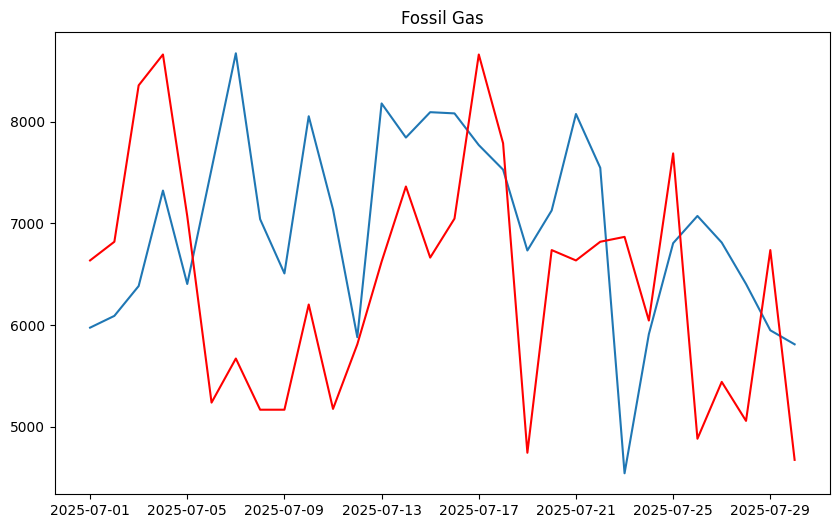

In [243]:
plt.figure(figsize=(10,6))
plt.plot(y_test)
plt.plot(comparador.drop(columns='Solar'), color='red')
plt.title(f'{column}');

Score de train: 0.9764650056857194
Score de test: 0.0081322606047175
MSE: 844579.2638083204
RMSE: 919.0099367299139
MAE: 760.0050825004101


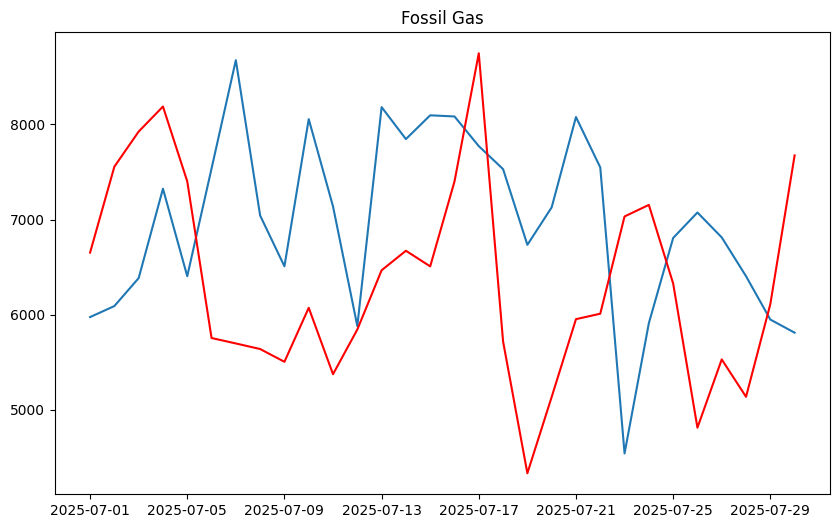

In [244]:
gmr = GradientBoostingRegressor()
gmr.fit(X_train, y_train)
X_pred = []

for i in range(X_train.shape[1]*-1, 0, 1):
    X_pred.append(X_train.iloc[-1, i])
X_pred.insert(0, y_train[-1])
X_pred.pop(-1)
y_pred = []

for day in range(30):
    prediction = gmr.predict(np.array([X_pred]))[0]
    y_pred.append(prediction)
    X_pred.insert(0, prediction)
    X_pred.pop(-1)

y_pred_series = pd.Series(y_pred, index=y_test.index, name='y_pred')
comparador = pd.concat([y_test, y_pred_series], axis=1)

print(f'Score de train: {gmr.score(X_train, y_train)}')
print(f'Score de test: {gmr.score(X_test, y_test)}')
print("MSE:", mean_squared_error(gmr.predict(X_test), y_test))
print("RMSE:", (root_mean_squared_error(gmr.predict(X_test), y_test)))
print("MAE:", mean_absolute_error(gmr.predict(X_test), y_test))

plt.figure(figsize=(10,6))
plt.plot(y_test)
plt.plot(comparador.drop(columns='Solar'), color='red')
plt.title(f'{column}');

Score de train: 0.9997890869652258
Score de test: -0.5609610591254561
MSE: 1329164.4538750728
RMSE: 1152.8939473668308
MAE: 912.1468587239583


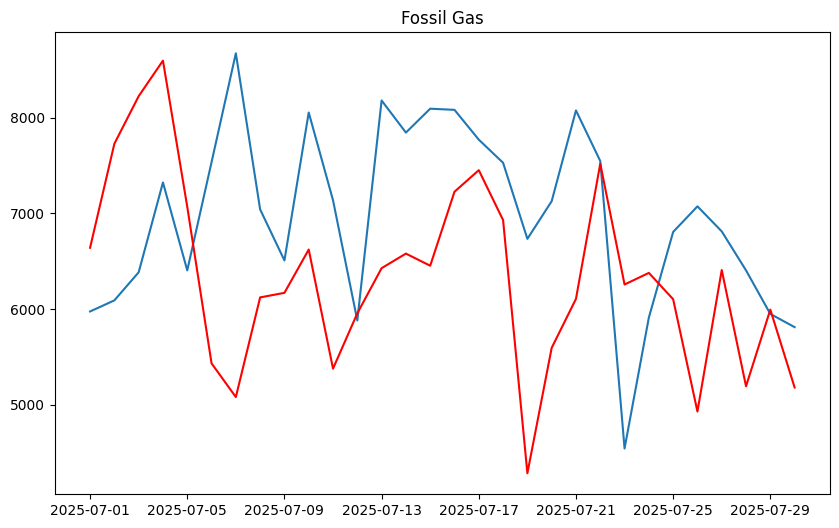

In [249]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
X_pred = []

for i in range(X_train.shape[1]*-1, 0, 1):
    X_pred.append(X_train.iloc[-1, i])
X_pred.insert(0, y_train[-1])
X_pred.pop(-1)
y_pred = []

for day in range(30):
    prediction = xgbr.predict(np.array([X_pred]))[0]
    y_pred.append(prediction)
    X_pred.insert(0, prediction)
    X_pred.pop(-1)

y_pred_series = pd.Series(y_pred, index=y_test.index, name='y_pred')
comparador = pd.concat([y_test, y_pred_series], axis=1)

print(f'Score de train: {xgbr.score(X_train, y_train)}')
print(f'Score de test: {xgbr.score(X_test, y_test)}')
print("MSE:", mean_squared_error(xgbr.predict(X_test), y_test))
print("RMSE:", (root_mean_squared_error(xgbr.predict(X_test), y_test)))
print("MAE:", mean_absolute_error(xgbr.predict(X_test), y_test))

plt.figure(figsize=(10,6))
plt.plot(y_test)
plt.plot(comparador.drop(columns='Solar'), color='red')
plt.title(f'{column}');

Score de train: 0.9919721656108459
Score de test: -0.17015400522644386
MSE: 996390.717253333
RMSE: 998.1937273161623
MAE: 758.5173333333333


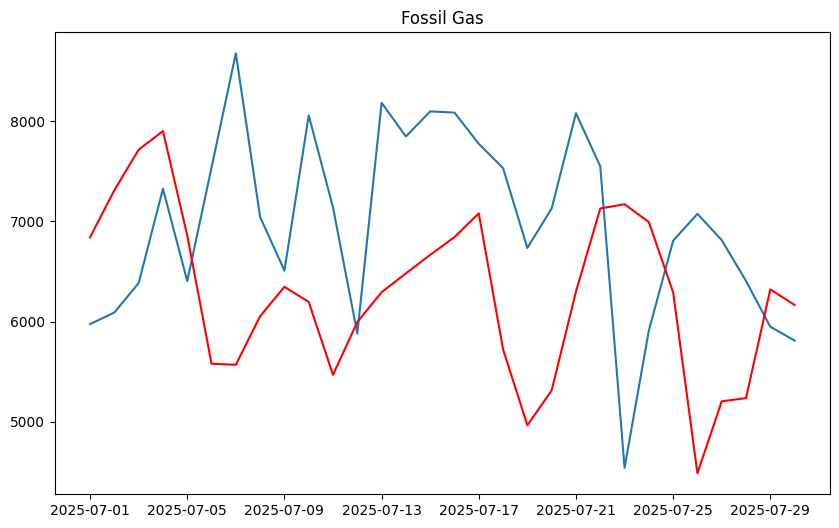

In [247]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
X_pred = []

for i in range(X_train.shape[1]*-1, 0, 1):
    X_pred.append(X_train.iloc[-1, i])
X_pred.insert(0, y_train[-1])
X_pred.pop(-1)
y_pred = []

for day in range(30):
    prediction = rfr.predict(np.array([X_pred]))[0]
    y_pred.append(prediction)
    X_pred.insert(0, prediction)
    X_pred.pop(-1)

y_pred_series = pd.Series(y_pred, index=y_test.index, name='y_pred')
comparador = pd.concat([y_test, y_pred_series], axis=1)

print(f'Score de train: {rfr.score(X_train, y_train)}')
print(f'Score de test: {rfr.score(X_test, y_test)}')
print("MSE:", mean_squared_error(rfr.predict(X_test), y_test))
print("RMSE:", (root_mean_squared_error(rfr.predict(X_test), y_test)))
print("MAE:", mean_absolute_error(rfr.predict(X_test), y_test))

plt.figure(figsize=(10,6))
plt.plot(y_test)
plt.plot(comparador.drop(columns='Solar'), color='red')
plt.title(f'{column}');


Métricas de la energía Total_Renovable
Score de train: 1.0
Score de test: 0.9998648029116837
MSE: 274.925
RMSE: 16.5808624624897
MAE: 12.883333333333333

Métricas de la energía Total_Fossil
Score de train: 1.0
Score de test: 0.9999459242735492
MSE: 145.975
RMSE: 12.082011421944609
MAE: 9.116666666666667

Métricas de la energía Nuclear
Score de train: 1.0
Score de test: 0.9998016305535755
MSE: 173.68333333333334
RMSE: 13.178897273039704
MAE: 6.2

Métricas de la energía Solar
Score de train: 1.0
Score de test: 0.9708680370775125
MSE: 50518.666666666664
RMSE: 224.76357949335713
MAE: 130.93333333333334

Métricas de la energía Fossil Gas
Score de train: 1.0
Score de test: 0.9999173119161444
MSE: 217.63333333333333
RMSE: 14.752400934537176
MAE: 9.566666666666666


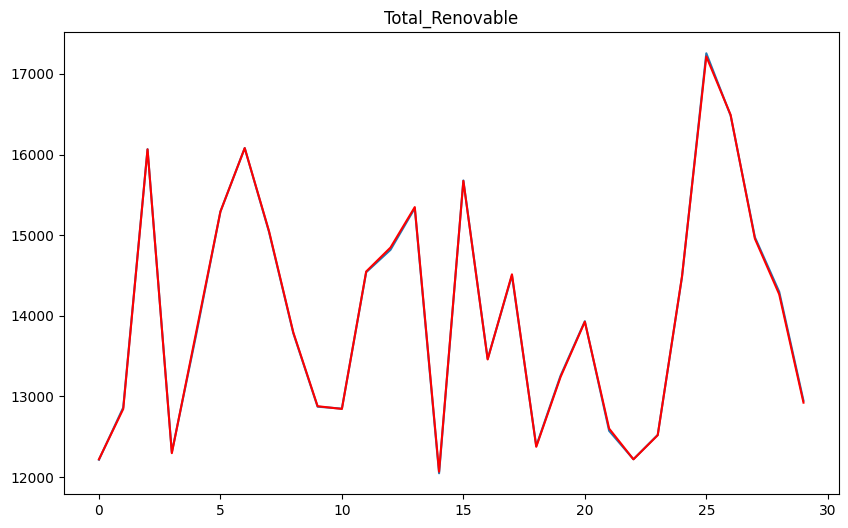

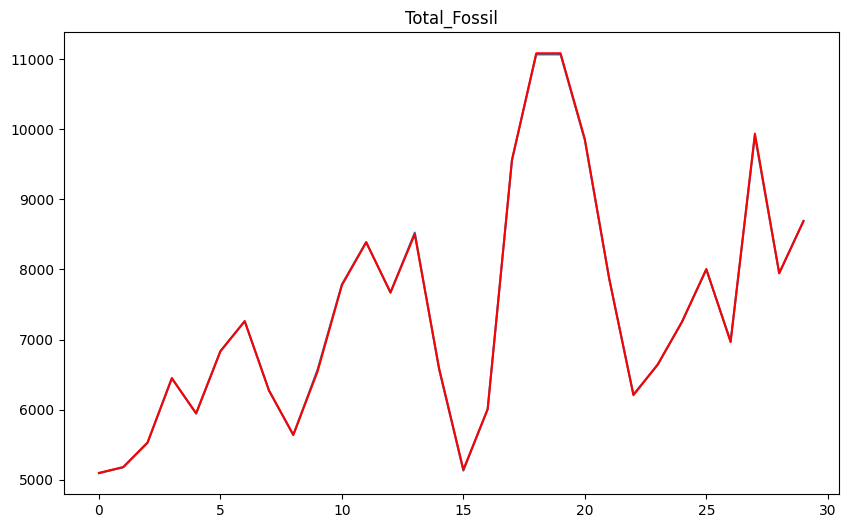

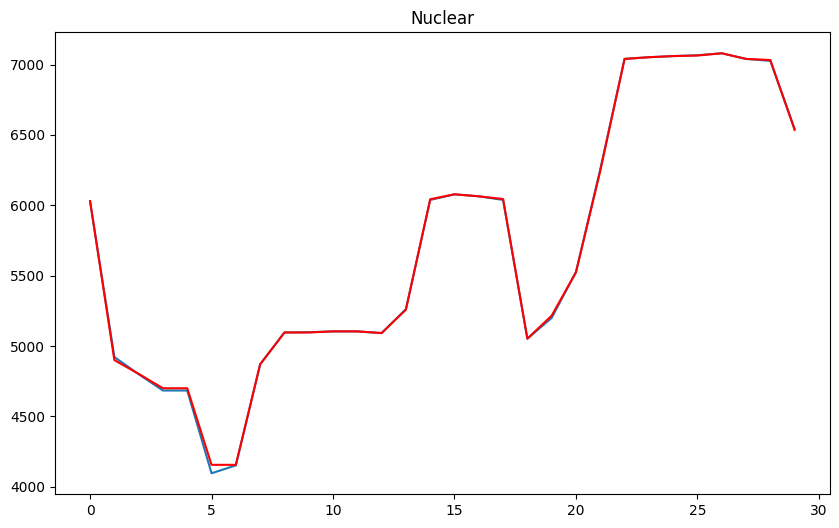

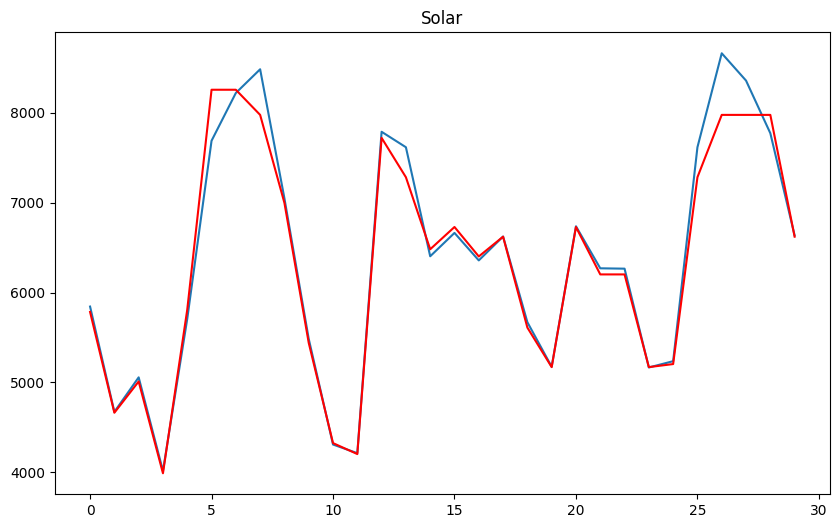

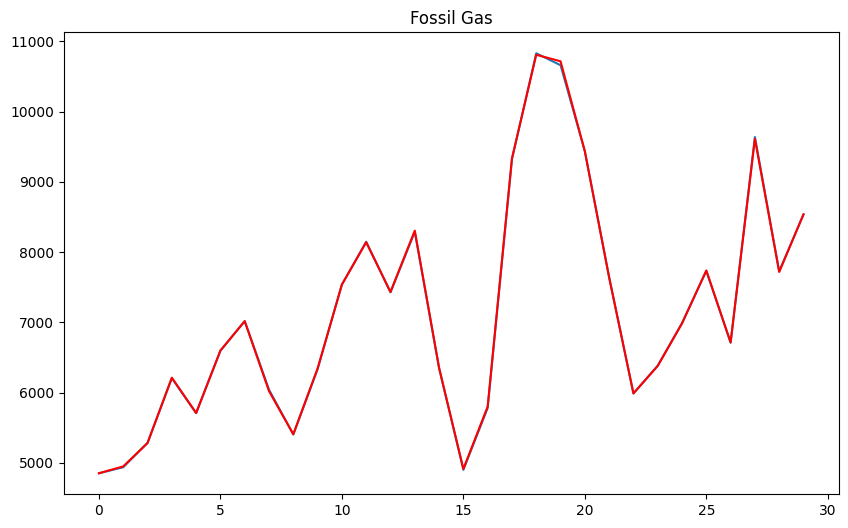

In [126]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error


for column, df in tipo_energia_dfs_dic.items():
    print()
    print('=='*30)
    print(f'Métricas de la energía {column}')
    print('=='*30)
    X = df.iloc[:, 1:].values
    y = df.iloc[:, 1].values 

    X_train = X[:-31]
    X_test = X[-30:]
    y_train = y[:-31]
    y_test = y[-30:]

    tree = DecisionTreeRegressor()
    tree.fit(X_train, y_train)
    print(f'Score de train: {tree.score(X_train, y_train)}')
    print(f'Score de test: {tree.score(X_test, y_test)}')
    print("MSE:", mean_squared_error(tree.predict(X_test), y_test))
    print("RMSE:", (root_mean_squared_error(tree.predict(X_test), y_test)))
    print("MAE:", mean_absolute_error(tree.predict(X_test), y_test))

    plt.figure(figsize=(10,6))
    plt.plot(y_test)
    plt.plot(tree.predict(X_test), color='red')
    plt.title(f'{column}');


Métricas de la energía Total_Renovable
Score de train: 0.9999907035923242
Score de test: 0.9999344400419664
MSE: 133.31700916667072
RMSE: 11.546298505004568
MAE: 7.1671666666667075

Métricas de la energía Total_Fossil
Score de train: 0.9999760789991009
Score de test: 0.9999843029918485
MSE: 42.37337000000182
RMSE: 6.5094830823961605
MAE: 4.752333333333414

Métricas de la energía Nuclear
Score de train: 0.9998786316542632
Score de test: 0.9999609141149878
MSE: 34.221836666666725
RMSE: 5.849943304568577
MAE: 3.2536666666667315

Métricas de la energía Solar
Score de train: 0.9999787611840765
Score de test: 0.9778074738039729
MSE: 38484.7679633333
RMSE: 196.17535004004276
MAE: 96.56566666666667

Métricas de la energía Fossil Gas
Score de train: 0.9999584406431561
Score de test: 0.9999791830206447
MSE: 54.78986083333538
RMSE: 7.402017348894515
MAE: 5.46216666666675


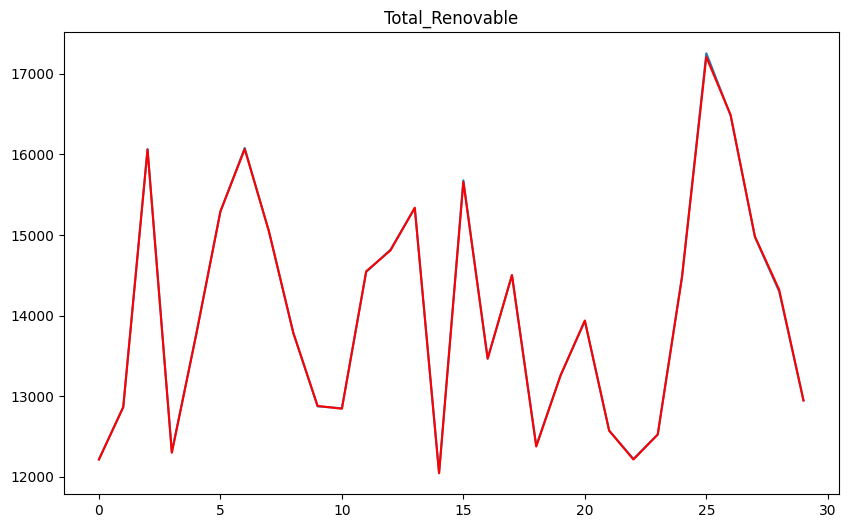

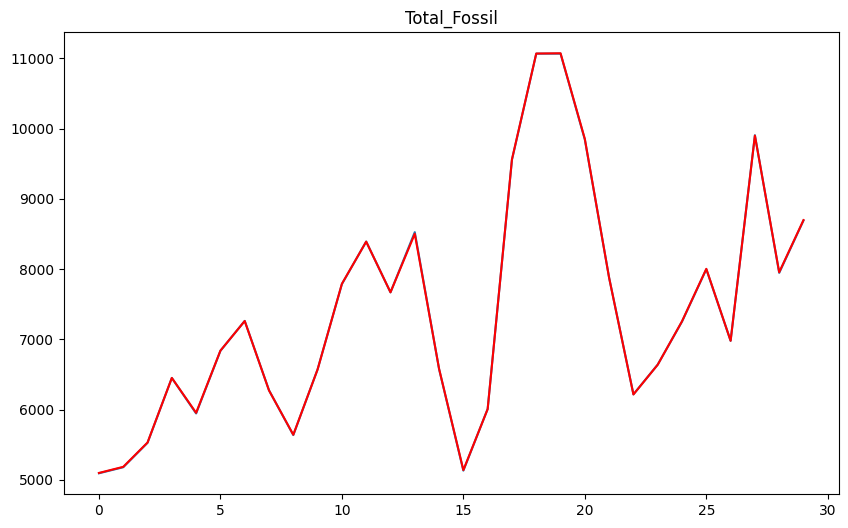

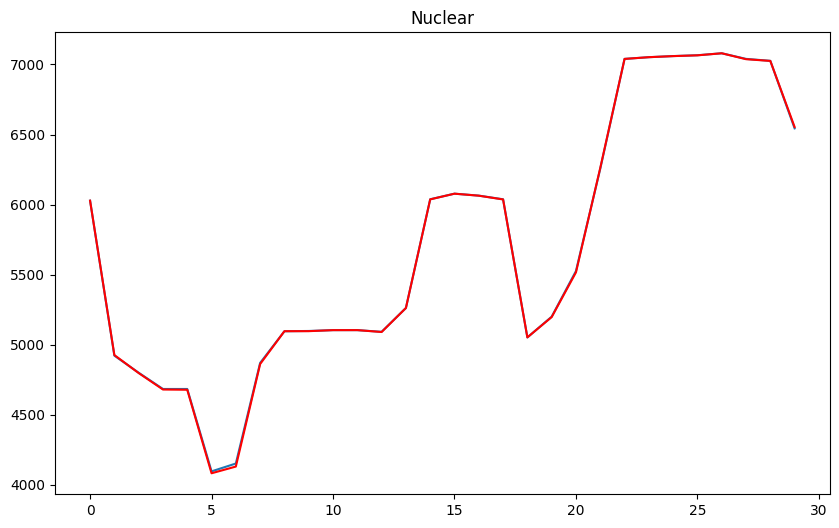

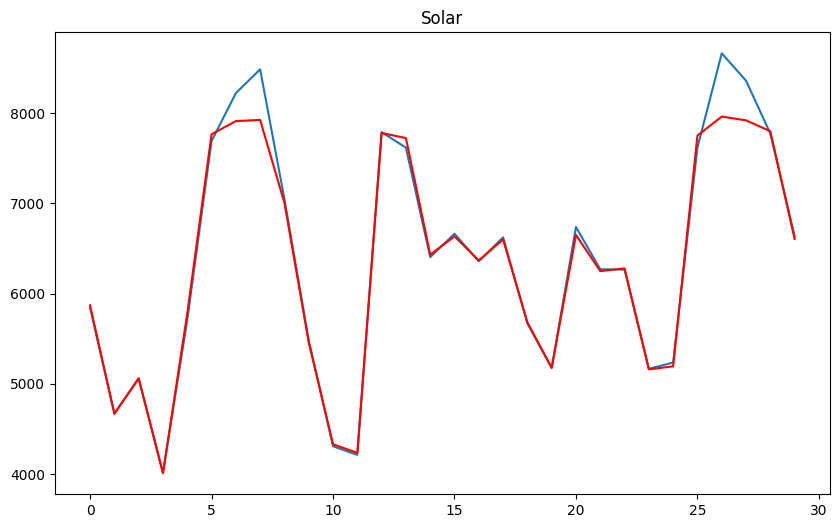

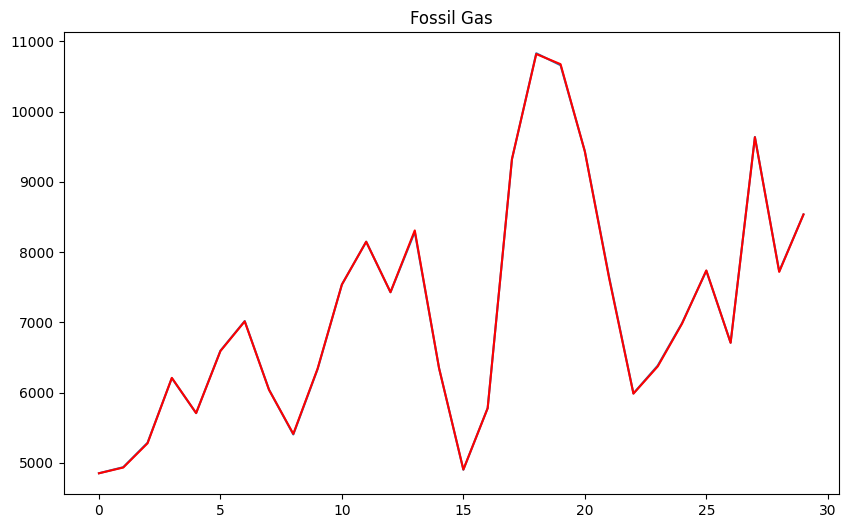

In [127]:
from sklearn.ensemble import RandomForestRegressor

for column, df in tipo_energia_dfs_dic.items():
    print()
    print('=='*30)
    print(f'Métricas de la energía {column}')
    print('=='*30)
    X = df.iloc[:, 1:].values
    y = df.iloc[:, 1].values 

    X_train = X[:-31]
    X_test = X[-30:]
    y_train = y[:-31]
    y_test = y[-30:]

    forest = RandomForestRegressor()
    forest.fit(X_train, y_train)
    print(f'Score de train: {forest.score(X_train, y_train)}')
    print(f'Score de test: {forest.score(X_test, y_test)}')
    print("MSE:", mean_squared_error(forest.predict(X_test), y_test))
    print("RMSE:", (root_mean_squared_error(forest.predict(X_test), y_test)))
    print("MAE:", mean_absolute_error(forest.predict(X_test), y_test))

    plt.figure(figsize=(10,6))
    plt.plot(y_test)
    plt.plot(forest.predict(X_test), color='red')
    plt.title(f'{column}');

In [296]:
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit


# Crear el pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('multi_model', MultiOutputRegressor(XGBRegressor()))
])

# Definir la grilla de hiperparámetros
param_grid = {
    'scaler': [MinMaxScaler(), StandardScaler(), None],
    'multi_model__estimator__n_estimators': [100, 200, 300],
    'multi_model__estimator__learning_rate': [0.01, 0.05, 0.1],
    'multi_model__estimator__max_depth': [3, 5, 7],
    'multi_model__estimator__subsample': [0.8, 1.0],
    'multi_model__estimator__colsample_bytree': [0.8, 1.0],
    'multi_model__estimator__gamma': [0, 1],
    'multi_model__estimator__reg_lambda': [0, 1, 10]
}

tscv = TimeSeriesSplit(n_splits=3)

# Configurar el GridSearchCV
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    scoring={'mae': 'neg_mean_absolute_error', 'r2': 'r2'},
    refit='mae',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

# Entrenar
grid_search.fit(X_train, y_train)

# Obtener el mejor pipeline ya entrenado
mejor_pipeline = grid_search.best_estimator_

# Predecir como antes
y_pred = mejor_pipeline.predict(X_test)[0]

# Evaluar
print("Mejores hiperparámetros:", grid_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros: {'scaler': MinMaxScaler(), 'multi_model__estimator__subsample': 0.8, 'multi_model__estimator__reg_lambda': 0, 'multi_model__estimator__n_estimators': 200, 'multi_model__estimator__max_depth': 5, 'multi_model__estimator__learning_rate': 0.05, 'multi_model__estimator__gamma': 1, 'multi_model__estimator__colsample_bytree': 0.8}


In [297]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      67.280844      4.579122         0.294789        0.011122   
1      98.282182      6.779505         0.350850        0.015353   
2      70.966696      5.959545         0.328806        0.083813   
3      38.310087      2.426258         0.198073        0.011474   
4     108.207818     10.888706         0.367104        0.008343   
5      65.010254      3.353947         0.244250        0.014089   
6      38.207277      2.179091         0.247423        0.014568   
7      78.896721      3.419691         0.318381        0.005670   
8      75.714569      2.257065         0.189478        0.041215   
9      12.893699      0.718756         0.142479        0.015160   

       param_scaler  param_multi_model__estimator__subsample  \
0    MinMaxScaler()                                      0.8   
1  StandardScaler()                                      1.0   
2  StandardScaler()                                      1.0   
3              None                                      1.0   
4              None                                      1.0   
5  StandardScaler()                                      0.8   
6              None                                      1.0   
7    MinMaxScaler()                                      0.8   
8              None                                      1.0   
9    MinMaxScaler()                                      1.0   

   param_multi_model__estimator__reg_lambda  \
0                                         0   
1                                        10   
2                                        10   
3                                         0   
4                                         0   
5                                         0   
6                                         0   
7                                        10   
8                                        10   
9                                        10   

   param_multi_model__estimator__n_estimators  \
0                                         200   
1                                         300   
2                                         200   
3                                         100   
4                                         300   
5                                         200   
6                                         300   
7                                         200   
8                                         100   
9                                         100   

   param_multi_model__estimator__max_depth  \
0                                        5   
1                                        5   
2                                        5   
3                                        5   
4                                        5   
5                                        5   
6                                        3   
7                                        5   
8                                        7   
9                                        3   

   param_multi_model__estimator__learning_rate  ...  split2_test_mae  \
0                                         0.05  ...      -765.349150   
1                                         0.10  ...      -828.991628   
2                                         0.01  ...      -950.584738   
3                                         0.10  ...      -776.650407   
4                                         0.10  ...      -783.723333   
5                                         0.05  ...      -765.349150   
6                                         0.10  ...      -771.393611   
7                                         0.05  ...      -819.116252   
8                                         0.05  ...      -880.368509   
9                                         0.01  ...     -1136.059022   

   mean_test_mae std_test_mae  rank_test_mae  split0_test_r2  split1_test_r2  \
0    -562.179545   147.365833              1        0.687853        0.761452   
1    -617.933719   153.990296             

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRFRegressor


ventana = 30 # Tamaño del set de lags
horizonte = 15 # Número de predicciones a futuro que queremos hacer

X_multi = []
Y_multi = []

serie = df_prueba['Solar'].dropna()

# Creacion de las series X_multi e Y_multi para entrenar el modelo restando la ventana y el horizonte
for i in range(len(serie) - ventana - horizonte + 1):
    X_multi.append(serie[i:i+ventana].values)
    Y_multi.append(serie[i+ventana:i+ventana+horizonte].values)

# Transformación de las series en matrices
X_multi = np.array(X_multi)
Y_multi = np.array(Y_multi)

# División en train/test 80/20 manualmente sin barajar
split_index = int(len(X_multi) * 0.8)
X_train, X_test = X_multi[:split_index], X_multi[split_index:]
y_train, y_test = Y_multi[:split_index], Y_multi[split_index:]

# Instanciamos el estimador dentro del MultiOutputRegressor para recibir multiples y_trains y con las que hacer multiples
# GradientBoostingRegressor(n_estimators= 200, max_depth= 3, learning_rate= 0.05)
# XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=5, learning_rate=0.1)
#modelo = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=5, learning_rate=0.1))
mejor_pipeline.fit(X_train, y_train)

# Crear índice de fechas futuro
inicio = serie.index[(horizonte + 1) * -1] + pd.Timedelta(days=1)
future_index = pd.date_range(start=inicio, periods=horizonte, freq='D')

y_pred = mejor_pipeline.predict(X_test)
y_pred_series = pd.Series(y_pred[0], index=future_index, name='y_pred')
y_test_flat = pd.Series(y_test[0], index=future_index)  # solo para mostrar el primero


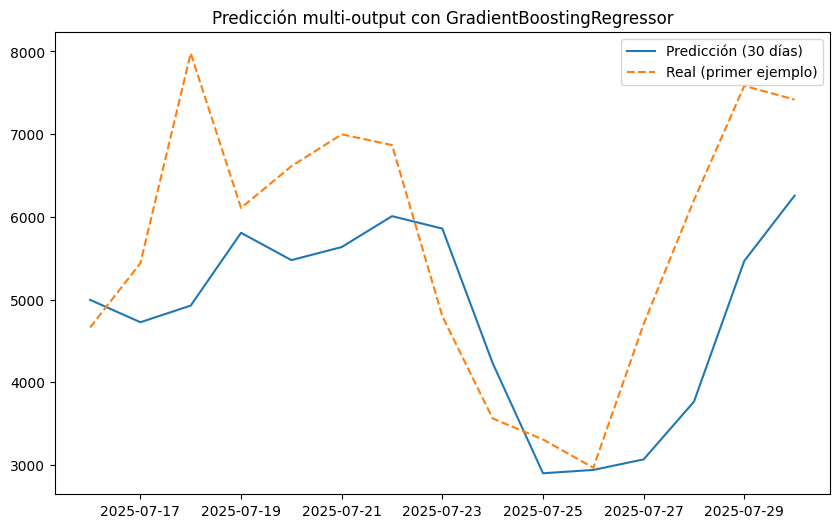

Score de train: 0.9880719117194829
Score de test: 0.8502456901636343
MAE total: 666.8094211833976
RMSE total: 1064.5508776002353


In [303]:
# Comparación visual
plt.figure(figsize=(10,6))
plt.plot(y_pred_series, label='Predicción (30 días)')
plt.plot(y_test_flat, label='Real (primer ejemplo)', linestyle='--')
plt.legend()
plt.title('Predicción multi-output con GradientBoostingRegressor')
plt.show()

# Métricas sobre el primer caso de test
print("Score de train:", mejor_pipeline.score(X_train, y_train))
print("Score de test:", mejor_pipeline.score(X_test, y_test))
print("MAE total:", mean_absolute_error(y_test, y_pred))
print("RMSE total:", np.sqrt(mean_squared_error(y_test, y_pred)))